In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()


import torch
import torch.nn as nn
import numpy as np
from auditory_cortex.dataloader2 import DataLoader
from auditory_cortex.dnn_feature_extractor import create_feature_extractor
from auditory_cortex.neural_data import create_neural_dataset, create_neural_metadata
from auditory_cortex.data_assembler import DNNDataAssembler, RandProjAssembler, STRFDataAssembler

import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
%matplotlib inline


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


/bin/sh: line 1: sox: command not found
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


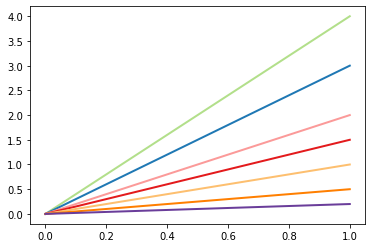

In [12]:
from palettable.colorbrewer import qualitative
paired_colors = qualitative.Paired_12.mpl_colors

color = paired_colors[2]
plt.plot([0, 1], [0, 4], color=color, lw=2)
color = paired_colors[1]
plt.plot([0, 1], [0, 3], color=color, lw=2)
color = paired_colors[4]
plt.plot([0, 1], [0, 2], color=color, lw=2)

color = paired_colors[5]
plt.plot([0, 1], [0, 1.5], color=color, lw=2)

color = paired_colors[6]
plt.plot([0, 1], [0, 1], color=color, lw=2)

color = paired_colors[7]
plt.plot([0, 1], [0, 0.5], color=color, lw=2)

color = paired_colors[9]
plt.plot([0, 1], [0, 0.2], color=color, lw=2)

In [3]:
model_name = 'whisper_tiny'
# model_name = 'deepspeech2'
feature_extractor = create_feature_extractor(model_name)

INFO:Changing convolution kernels for: whisper_tiny


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
all_modules = dict([*feature_extractor.model.named_modules()])

In [12]:
all_modules.keys()

dict_keys(['', 'conv', 'conv.seq_module', 'conv.seq_module.0', 'conv.seq_module.1', 'conv.seq_module.2', 'conv.seq_module.3', 'conv.seq_module.4', 'conv.seq_module.5', 'rnns', 'rnns.0', 'rnns.0.rnn', 'rnns.1', 'rnns.1.batch_norm', 'rnns.1.batch_norm.module', 'rnns.1.rnn', 'rnns.2', 'rnns.2.batch_norm', 'rnns.2.batch_norm.module', 'rnns.2.rnn', 'rnns.3', 'rnns.3.batch_norm', 'rnns.3.batch_norm.module', 'rnns.3.rnn', 'rnns.4', 'rnns.4.batch_norm', 'rnns.4.batch_norm.module', 'rnns.4.rnn', 'fc', 'fc.0', 'fc.0.module', 'fc.0.module.0', 'fc.0.module.1', 'inference_softmax', 'criterion', 'wer', 'cer'])

In [5]:
all_modules['']

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(11,), stride=(1,), padding=(5,))
      (conv2): Conv1d(384, 384, kernel_size=(11,), stride=(2,), padding=(5,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        

In [19]:
model_name = 'deepspeech2'
feature_extractor = create_feature_extractor(model_name)

INFO:Lightning automatically upgraded your loaded checkpoint from v1.1.5 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../depot/jgmakin/data/auditory_cortex/results/pretrained_weights/deepspeech2/librispeech_pretrained_v3.ckpt`


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:203: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend s

In [ ]:
feature_extractor.model.conv.seq_module[0] = nn.Conv2d(1, 32, kernel_size=(41, 3), stride=(2, 2), padding=(20, 1)).cuda()
feature_extractor.model.conv.seq_module[3] = nn.Conv2d(32, 32, kernel_size=(21, 3), stride=(2, 1), padding=(10, 1)).cuda()

In [25]:
x = torch.randn(1, 1, 100, 100).cuda()
x = feature_extractor.model.conv.seq_module[0](x)
print(x.shape)
# feature_extractor.model.model.encoder.conv2(x).shape

torch.Size([1, 32, 50, 50])


In [20]:
feature_extractor.model

DeepSpeech(
  (conv): MaskConv(
    (seq_module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
      (1): Identity()
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
      (4): Identity()
      (5): Hardtanh(min_val=0, max_val=20, inplace=True)
    )
  )
  (rnns): Sequential(
    (0): BatchRNN(
      (rnn): LSTM(1312, 1024, bidirectional=True)
    )
    (1): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirectional=True)
    )
    (2): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirectional=True)
    )
    (3): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, 

In [17]:
x = torch.randn(1, 80, 100).cuda()
x = feature_extractor.model.model.encoder.conv1(x)
print(x.shape)
feature_extractor.model.model.encoder.conv2(x).shape


torch.Size([1, 384, 100])


torch.Size([1, 384, 50])

In [11]:
feature_extractor.model.model.encoder.conv1 = nn.Conv1d(80, 384, kernel_size=(11,), stride=(1,), padding=(5,)).cuda()

In [16]:
feature_extractor.model.model.encoder.conv1 = nn.Conv1d(80, 384, kernel_size=(11,), stride=(1,), padding=(5,)).cuda()
feature_extractor.model.model.encoder.conv2 = nn.Conv1d(384, 384, kernel_size=(11,), stride=(2,), padding=(5,)).cuda()

In [8]:
feature_extractor.model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(11,), stride=(1,), padding=(5,))
      (conv2): Conv1d(384, 384, kernel_size=(11,), stride=(2,), padding=(5,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        

In [2]:
dataset_name = 'ucsf'
session = 200206
dataset_obj = create_neural_dataset(dataset_name, session)

INFO:NeuralData:  Creating object for session: 200206 ... 
INFO:Done.


In [9]:
model_name = 'cochresnet50'
# model_name = 'cochcnn9'
# model_name = 'wav2letter_modified'
feature_extractor = create_feature_extractor(model_name)

dataloader = DataLoader(dataset_obj, feature_extractor)

=> loading checkpoint '/scratch/gilbreth/ahmedb/cache/cochdnns/model_checkpoints/audio_rep_training_cochleagram_1/standard_training_word_and_audioset_and_speaker_decay_lr/542752d7-9849-49ff-b84a-6758a81585b4/5_checkpoint.pt'
=> loaded checkpoint '/scratch/gilbreth/ahmedb/cache/cochdnns/model_checkpoints/audio_rep_training_cochleagram_1/standard_training_word_and_audioset_and_speaker_decay_lr/542752d7-9849-49ff-b84a-6758a81585b4/5_checkpoint.pt' (epoch 6)


In [10]:
layers = feature_extractor.reset_model_parameters()

INFO:Randomly 'resetting' the network parameters...


In [13]:
params = [*feature_extractor.model.parameters()]

In [17]:
state_dict = feature_extractor.model.state_dict()

In [18]:
state_dict.keys()

odict_keys(['preproc.normalize.new_mean', 'preproc.normalize.new_std', 'model.0.full_rep.rep.downsampling_op.downsample_filter', 'model.0.full_rep.rep.Cochleagram.compute_subbands.coch_filters', 'model.0.full_rep.rep.Cochleagram.downsampling.downsample_filter', 'model.1.conv1.weight', 'model.1.bn1.weight', 'model.1.bn1.bias', 'model.1.bn1.running_mean', 'model.1.bn1.running_var', 'model.1.bn1.num_batches_tracked', 'model.1.layer1.0.conv1.weight', 'model.1.layer1.0.bn1.weight', 'model.1.layer1.0.bn1.bias', 'model.1.layer1.0.bn1.running_mean', 'model.1.layer1.0.bn1.running_var', 'model.1.layer1.0.bn1.num_batches_tracked', 'model.1.layer1.0.conv2.weight', 'model.1.layer1.0.bn2.weight', 'model.1.layer1.0.bn2.bias', 'model.1.layer1.0.bn2.running_mean', 'model.1.layer1.0.bn2.running_var', 'model.1.layer1.0.bn2.num_batches_tracked', 'model.1.layer1.0.conv3.weight', 'model.1.layer1.0.bn3.weight', 'model.1.layer1.0.bn3.bias', 'model.1.layer1.0.bn3.running_mean', 'model.1.layer1.0.bn3.running_va

In [19]:
state_dict['model.0.full_rep.rep.downsampling_op.downsample_filter'].shape

torch.Size([1, 1, 1001])

In [20]:
state_dict['model.0.full_rep.rep.Cochleagram.compute_subbands.coch_filters'].shape

torch.Size([211, 20001, 2])

In [4]:
mVocs = False
stim_ids = [1,2,3,4]
stim_audios = {}
stim_durations = {}
sampling_rate = 16000
for stim_id in stim_ids:
    stim_audios[stim_id] = dataloader.get_stim_audio(stim_id, mVocs=mVocs)
    stim_durations[stim_id] = dataloader.get_stim_duration(stim_id, mVocs=mVocs)

In [5]:
stim_durations

{1: 1.817625, 2: 2.2528125, 3: 2.56, 4: 2.521625}

In [6]:
raw_DNN_features = dataloader.feature_extractor.extract_features(
                    stim_audios, sampling_rate, stim_durations, dataloader.pad_time
                    )

In [7]:
layer_id = 1
stim_id = 1
raw_DNN_features[layer_id][stim_id].shape

(212, 2000)

In [34]:
raw_DNN_features[layer_id][stim_id][:, 10]

array([0.02914859, 0.02844433, 0.02542241, 0.0190813 , 0.01866483,
       0.02219895, 0.02172198, 0.01750751, 0.01255332, 0.01826014,
       0.01939159, 0.01740272, 0.01132667, 0.0149336 , 0.01777368,
       0.01715096, 0.01320939, 0.01221812, 0.01628075, 0.01680135,
       0.01479292, 0.01137208, 0.01457022, 0.01636976, 0.01572221,
       0.01275356, 0.01289027, 0.01569045, 0.01614871, 0.01453734,
       0.01244571, 0.01464823, 0.01622342, 0.01581902, 0.01373958,
       0.0136947 , 0.01591764, 0.01656618, 0.01547674, 0.01393242,
       0.01533754, 0.01690427, 0.01685149, 0.01545755, 0.01516156,
       0.0168799 , 0.01775683, 0.01725021, 0.0162932 , 0.01693829,
       0.01825784, 0.01871333, 0.01843878, 0.0182387 , 0.01868899,
       0.01969682, 0.02094333, 0.02175647, 0.02101968, 0.02006845,
       0.02456607, 0.02981188, 0.03323409, 0.03458439, 0.0336139 ,
       0.0293453 , 0.0242987 , 0.02990635, 0.03447599, 0.03538116,
       0.03324071, 0.02766619, 0.02584872, 0.03003891, 0.03074

In [21]:
length = 33000 + 40000
stim_audios = {1: np.random.randn(length)}
sampling_rate = 20000
pad_time = 0.35 # seconds 
stim_features = feature_extractor.extract_features(stim_audios, sampling_rate, pad_time=pad_time)

In [22]:
for k, v in stim_features.items():
    print(f'{v[1].shape}')

(781, 211)
(391, 6784)
(197, 3392)
(197, 13568)
(100, 13824)
(51, 14336)
(27, 14336)


In [14]:
audio = np.random.randn(27000)  
context_samples = 7000
retain_context = False
stim_features = feature_extractor.extract_features_for_clip(
    audio, context_samples=context_samples, retain_context=retain_context)



In [15]:
for k, v in stim_features.items():
    print(f'{v.shape}')

torch.Size([196, 211])
torch.Size([98, 6784])
torch.Size([50, 3392])
torch.Size([50, 13568])
torch.Size([26, 13824])
torch.Size([13, 14336])
torch.Size([7, 14336])


In [16]:
from scipy.signal import resample

audio = np.random.randn(32000)  # Simulated audio data
sampling_rate = 16000  # Example sampling rate
duration = 2
pad_time = None

In [17]:
if sampling_rate != feature_extractor.sampling_rate:
    n_samples = int(audio.size*feature_extractor.sampling_rate/sampling_rate)
    audio = resample(audio, n_samples)

if pad_time is not None:
    # print(f"Padding audio by {pad_time} seconds...")
    pad = int(pad_time*feature_extractor.sampling_rate)
    padding = np.zeros((pad, ))
    audio = np.concatenate([padding, audio])

In [18]:
target_length = 40000
audio = np.random.randn(40000)  # Simulated audio data
if audio.shape[0] > target_length:
        raise ValueError(f"Audio is longer than target length {target_length}")
    
padding_length = target_length - audio.shape[0]
padded_audio = np.pad(audio, (0, padding_length), mode='constant')
stim_features = feature_extractor.get_features(padded_audio)

In [ ]:
audio = np.random.randn(30000)  # Simulated audio data
context_length = 10000
list_clips = feature_extractor.get_short_clips(audio, context_length=context_length)
print(len(list_clips))
for clip in list_clips:
    print(clip.shape)

In [ ]:
audio = np.random.randn(5)  # Simulated audio data

clip_length = 4  # Length of each audio clip in samples
context_length = 2  # Length of context in samples
num_samples = audio.shape[0]
idx = 0
list_clips = []
while num_samples > clip_length:

    audio_clip = audio[idx*clip_length:(idx+1)*clip_length]
    if idx == 0:
        audio_context = np.zeros((context_length,))
    else:
        audio_context = audio[idx*clip_length-context_length:idx*clip_length]
    audio_clip = np.concatenate([audio_context, audio_clip])
    list_clips.append(audio_clip)
    idx += 1
    num_samples -= clip_length

audio_clip = audio[idx*clip_length:]
if idx == 0:
    audio_context = np.zeros((context_length,))
else:
    audio_context = audio[idx*clip_length-context_length:idx*clip_length]
audio_clip = np.concatenate([audio_context, audio_clip])
list_clips.append(audio_clip)


In [ ]:
print(len(list_clips))
for clip in list_clips:
    print(clip.shape)

2
(6,)
(3,)


In [ ]:
list_clips

[array([ 0.        ,  0.        , -0.01800353,  0.07138147,  0.37861008,
         0.4565995 ]),
 array([ 0.37861008,  0.4565995 , -0.04564193])]

In [ ]:
idx

1

In [ ]:
stim_features.keys()

dict_keys(['model.0', 'model.1.relu', 'model.1.maxpool', 'model.1.layer1', 'model.1.layer2', 'model.1.layer3', 'model.1.layer4'])

In [ ]:
features = {}
for layer_id in feature_extractor.layer_ids:
    layer_name = feature_extractor.layer_names[layer_id]
    features[layer_id] = stim_features[layer_name]

In [ ]:
feature_extractor.layer_types

['conv', 'conv', 'conv', 'conv', 'conv', 'conv', 'conv']

In [ ]:
feature_extractor.model_name

'cochresnet50'

In [ ]:
for layer_id in features:

    print(features[layer_id].shape)

torch.Size([390, 211])
torch.Size([195, 6784])
torch.Size([98, 3392])
torch.Size([98, 13568])
torch.Size([49, 13824])
torch.Size([25, 14336])
torch.Size([13, 14336])


In [ ]:
audio.shape

(40000,)

In [27]:
from pycochleagram import cochleagram as cgram
aud = np.random.randn(16000)  # Simulated audio data, e.g., a 2-second waveform at 16 kHz
spect = cgram.human_cochleagram(
                    aud,                # Your 2-second waveform (e.g., a NumPy array of shape (32000,) for 16 kHz)
                    sr=16000,           # Sampling rate of the waveform
                    n=50,              # Number of filters in the filterbank
                    low_lim=50,         # Lower frequency limit in Hz
                    hi_lim=8000,       # Upper frequency limit in Hz
                    sample_factor=4,    # Determines filter overlap (87.5% overlap for sample_factor=4)
                    downsample=None,     # Downsample envelopes to 200 Hz
                    nonlinearity='power' # Apply 3/10 power compression to simulate basilar membrane compression
                )

here


In [28]:
spect.shape

(211, 16000)

In [ ]:
def extract_features(self, stim_audios, sampling_rate, stim_durations=None, pad_time=None):
        """
        Returns raw features for all layers of the DNN..!

        Args:
            stim_audios (dict): dictionary of audio inputs for each sentence.
                {stim_id: audio}
            sampling_rate (int): sampling rate of the audio inputs.
            stim_durations (dict): dictionary of sentence durations.
                {stim_id: duration}
            pad_time (float): amount of padding time in seconds.

        Returns:
            dict of dict: read this as features[layer_id][stim_id]
        """
        features = {id:{} for id in self.layer_ids}
        for stim_id, audio in stim_audios.items():

            if sampling_rate != self.sampling_rate:
                n_samples = int(audio.size*self.sampling_rate/sampling_rate)
                audio = resample(audio, n_samples)
            
            if pad_time is not None:
                # print(f"Padding audio by {pad_time} seconds...")
                pad = int(pad_time*self.sampling_rate)
                padding = np.zeros((pad, ))
                audio = np.concatenate([padding, audio])

            # # needed only for Whisper...!
            if 'whisper' in self.model_name:
                bin_width = 20/1000.0   #20 ms for all layers except the very first...
                sent_duration = stim_durations[stim_id]
                if pad_time is not None:
                    sent_duration += pad_time
                # sent_samples = int(np.ceil(round(sent_duration/bin_width, 3)))
                sent_samples = int((sent_duration + bin_width/2)/bin_width)

            # self.translate(audio, grad=False)
            # _ = self.fwd_pass(audio)
            stim_features = self.get_features(audio)
            for layer_id in self.layer_ids:
                # features[layer_id][stim_id] = self.get_features(layer_id)
                layer_name = self.get_layer_name(layer_id)
                features[layer_id][stim_id] = stim_features[layer_name]
                if 'whisper' in self.model_name:
                    ## whisper networks gives features for 30s long clip,
                    ## extracting only the true initial samples...
                    layer_name = self.get_layer_name(layer_id)
                    if layer_name == 'model.encoder.conv1':
                        # sampling rate is 100 Hz for very first layer
                        # and 50 Hz for all the other layers...
                        feature_samples = 2*sent_samples
                    else:
                        feature_samples = sent_samples
                    features[layer_id][stim_id] = features[layer_id][stim_id][:feature_samples]
            del stim_features
            collected = gc.collect()
            # logger.debug(f"Garbage collector: collected {collected} objects.")
        return features

In [ ]:
from auditory_cortex.dataloader2 import DataLoader
from auditory_cortex.plotters.plotter_utils import PlotterUtils
import auditory_cortex.utils as utils
from auditory_cortex.encoding import TRF
session = 190726
save_tikz = False
mVocs = True
sent_id = 308
plot_spectrogram = True
bin_width = 50


mean_line_width = 2
ind_trial_width = 1
alpha = 0.3


model_name = 'deepspeech2'
lag = 200
dataset_name = 'ucsf'

In [ ]:
layers = {
        'wav2vec2': 5,
        'wav2letter_modified': 6,
        'deepspeech2': 3,
        'speech2text': 2,
        'whisper_tiny': 2,
        'whisper_base': 2
    }
session = str(session)
dataset_obj = create_neural_dataset('ucsf', session)
# dataloader = DataLoader(dataset_obj)
# test_stim_ids = dataloader.get_testing_stim_ids(mVocs)
# assert sent_id in test_stim_ids, "Invalid sent ID, choose from"+\
#                 f" {list(test_stim_ids)}"

INFO:NeuralData:  Creating object for session: 190726 ... 
INFO:Done.


In [ ]:
spikes = dataloader.get_session_spikes(
    bin_width=bin_width, repeated=True, mVocs=mVocs
    )
all_trials_spike_counts = np.stack(
    [spikes[sent_id][ch] for ch in spikes[sent_id].keys()],
    axis=-1
    )

In [ ]:
all_trials_spike_counts.shape

(11, 47, 64)

In [ ]:

layer = layers[model_name]
    
# dataset_obj = create_neural_dataset('ucsf', session)
feature_extractor = create_feature_extractor(model_name, shuffled=False)
dataset = DNNDataAssembler(
    dataset_obj, feature_extractor, layer, bin_width=bin_width, mVocs=mVocs,
    )
# trf_obj = TRF(model_name, dataset)
# # dataset = DNNDataset(
# # 		session, bin_width, model_name, layer
# # 		)
# # trf_obj = TRF(model_name, dataset)
# saved_predictions[model_name] = trf_obj.neural_prediction(
#         model_name, session, layer, bin_width, [sent_id], 'ucsf',
#         lag=200
#     )[0]

In [ ]:
trf_obj = TRF(model_name, dataset)

INFO:TRF object created for 'whisper_base' model.


In [ ]:
trf_model = trf_obj.load_saved_model(
            model_name, session, layer, bin_width, shuffled=False,
            LPF=False, mVocs=mVocs, dataset_name=dataset_name,
            tmax=lag
            )

INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-False
INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True
INFO:Reading from file: /scratch/gilbreth/ahmedb/cache/trf/whisper_base/alphas/whisper_base_layer_2_sess_200206_trf200_50ms.pkl
INFO:GpuTRF object created with alpha=[  1.    1.   10.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    0.1   1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    0.1   1.    1.    1.
   1.    1.    1.    1.    1.    1.  100.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   0.1   1.    0.1   1. ], tmin=0, tmax=0.2, sfreq=20.0


In [ ]:
X, _ = trf_obj.dataset_assembler.get_testing_data([308])

In [ ]:
saved_predictions= trf_obj.neural_prediction(
        model_name, session, layer, bin_width, [sent_id], 'ucsf',
        lag=200
    )[0]

INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-False
INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True
INFO:Reading from file: /scratch/gilbreth/ahmedb/cache/trf/whisper_base/alphas/whisper_base_layer_2_sess_200206_trf200_50ms.pkl
INFO:GpuTRF object created with alpha=[  1.    1.   10.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    0.1   1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    0.1   1.    1.    1.
   1.    1.    1.    1.    1.    1.  100.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   0.1   1.    0.1   1. ], tmin=0, tmax=0.2, sfreq=20.0


In [ ]:
trf_model = trf_obj.load_saved_model(
            model_name, session, layer, bin_width, shuffled=False,
            LPF=False, mVocs=mVocs, dataset_name=dataset_name,
            tmax=lag
            )

INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-False
INFO:Results not found.
INFO:Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True
INFO:Results not found.


In [ ]:
trf_model

In [ ]:




# # # getting all trials...
# all_trials_spike_counts = dataloader.get_neural_data_for_repeated_trials(
#         session, bin_width=bin_width,
#         stim_ids=sent_ids
#     )

### getting predictions using the model..
if saved_predictions is None:
    saved_predictions = {}

prediction_colors = {}
if model_name not in saved_predictions.keys():
    layer = layers[model_name]
    
    # dataset_obj = create_neural_dataset('ucsf', session)
    feature_extractor = create_feature_extractor(model_name, shuffled=False)
    dataset = DNNDataAssembler(
        dataset_obj, feature_extractor, layer, bin_width=bin_width, mVocs=mVocs,
        )
    trf_obj = TRF(model_name, dataset)
    # dataset = DNNDataset(
    # 		session, bin_width, model_name, layer
    # 		)
    # trf_obj = TRF(model_name, dataset)
    saved_predictions[model_name] = trf_obj.neural_prediction(
            model_name, session, layer, bin_width, [sent_id], 'ucsf',
            lag=200
        )[0]

In [1]:
import os
import importlib

coch_dir = '/home/ahmedb/projects/Wav2Letter'
model_directory_base = os.path.join(coch_dir, 'cochdnn', 'model_directories')

In [2]:
# model = 'kell2018_word_speaker_audioset'
model = 'resnet50_word_speaker_audioset_randomize_weights'
# model = 'resnet50_word_speaker_audioset'
# model = 'resnet50_word'
build_network_spec = importlib.util.spec_from_file_location("build_network",
                        os.path.join(model_directory_base, model, 'build_network.py'))
build_network = importlib.util.module_from_spec(build_network_spec)
build_network_spec.loader.exec_module(build_network)

model, ds, metamer_layers = build_network.main(return_metamer_layers=True)


### WARNING: UNABLE TO FIND JSIN AUDIO TRAINING DATASET FILES. IF TRAINING AUDIO MODELS, CHANGE PATH SPECIFIED IN analysis_scripts/default_paths.py. MODELS CAN BE LOADED AND TESTED WITHOUT THESE FILES. ###
=> loading checkpoint '/scratch/gilbreth/ahmedb/cache/cochdnns/model_checkpoints/audio_rep_training_cochleagram_1/standard_training_word_and_audioset_and_speaker_decay_lr/542752d7-9849-49ff-b84a-6758a81585b4/5_checkpoint.pt'
=> loaded checkpoint '/scratch/gilbreth/ahmedb/cache/cochdnns/model_checkpoints/audio_rep_training_cochleagram_1/standard_training_word_and_audioset_and_speaker_decay_lr/542752d7-9849-49ff-b84a-6758a81585b4/5_checkpoint.pt' (epoch 6)
tensor([ 3.1657e-03,  3.9340e-01,  1.0428e-04,  3.6352e-01, -2.6409e-04,
         3.5849e-01, -4.5819e-04,  2.0557e-03,  5.6803e-01,  3.7126e-01,
         4.4450e-01, -2.8197e-01,  4.7561e-04,  4.4405e-01,  5.1926e-02,
         3.1890e-01,  1.9553e-03,  3.5851e-01,  8.1130e-05,  4.2886e-01,
        -7.8903e-04,  4.3794e-01,  4.5542e-

In [ ]:
all_modules = dict([*model.named_modules()])

In [ ]:
all_modules.keys()

dict_keys(['', 'preproc', 'preproc.normalize', 'model', 'model.0', 'model.0.full_rep', 'model.0.full_rep.rep', 'model.0.full_rep.rep.envelope_extraction', 'model.0.full_rep.rep.downsampling_op', 'model.0.full_rep.rep.Cochleagram', 'model.0.full_rep.rep.Cochleagram.compute_subbands', 'model.0.full_rep.compression', 'model.0.full_rep.compression.compression_function', 'model.1', 'model.1.batchnorm0', 'model.1.conv0', 'model.1.relu0', 'model.1.maxpool0', 'model.1.batchnorm1', 'model.1.conv1', 'model.1.relu1', 'model.1.maxpool1', 'model.1.batchnorm2', 'model.1.conv2', 'model.1.relu2', 'model.1.conv3', 'model.1.relu3', 'model.1.conv4', 'model.1.relu4', 'model.1.avgpool', 'model.1.fullyconnected', 'model.1.relufc', 'model.1.dropout', 'model.1.classification', 'model.1.classification.signal/word_int', 'model.1.classification.signal/speaker_int', 'model.1.classification.noise/labels_binary_via_int', 'model.1.fake_relu_dict', 'model.1.fake_relu_dict.relu0', 'model.1.fake_relu_dict.relu1', 'mode

In [ ]:
all_modules['model.1']

AuditoryCNNMultiTask(
  (batchnorm0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0): Conv2dSame(1, 96, kernel_size=(7, 14), stride=(3, 3), bias=False)
  (relu0): ReLU()
  (maxpool0): MaxPool2dSame(kernel_size=[2, 5], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (batchnorm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2dSame(96, 256, kernel_size=(4, 8), stride=(2, 2), bias=False)
  (relu1): ReLU()
  (maxpool1): MaxPool2dSame(kernel_size=[2, 5], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2dSame(256, 512, kernel_size=(2, 5), stride=(1, 1), bias=False)
  (relu2): ReLU()
  (conv3): Conv2dSame(512, 1024, kernel_size=(2, 5), stride=(1, 1), bias=False)
  (relu3): ReLU()
  (conv4): Conv2dSame(1024, 512, kernel_size=(2, 5), stride=(1, 1), bias=False)
  (relu4):

In [ ]:
all_modules['model.1.avgpool']

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
rand_input = torch.randn(40000).cuda()
model.eval()
with torch.no_grad():
    # out2 = model(rand_input)
    features = model.preproc(rand_input)
    # out = model.model[0](features)
    out1 = all_modules['model.0'](features)
    out2 = all_modules['model.1'](out1)

In [ ]:
features.shape

torch.Size([1, 1, 40000])

In [ ]:
out1.shape

torch.Size([1, 1, 211, 390])

In [ ]:
out1 = torch.randn(1, 1, 211, 500).cuda()
with torch.no_grad():
    out2 = all_modules['model.1'](out1)


In [ ]:
out2.keys()

dict_keys(['signal/word_int', 'signal/speaker_int', 'noise/labels_binary_via_int'])

In [ ]:
all_modules['model.0'].full_rep.rep.Cochleagram.downsampling

SincWithKaiserWindow()

In [ ]:
all_modules['model.0'].full_rep.rep

AudioToCochleagram(
  (envelope_extraction): HilbertEnvelopeExtraction()
  (downsampling_op): SincWithKaiserWindow()
  (Cochleagram): Cochleagram(
    (compute_subbands): ComputeSubbands()
    (envelope_extraction): HilbertEnvelopeExtraction()
    (downsampling): SincWithKaiserWindow()
  )
)

In [ ]:
out1.shape

torch.Size([1, 1, 211, 390])

In [ ]:
with torch.no_grad():

    rand_features = torch.randn(1, 1, 50000).cuda()
    out2 = all_modules['model.0'](rand_features)

RuntimeError: The size of tensor a (25001) must match the size of tensor b (20001) at non-singleton dimension 3

In [ ]:
aud = np.random.randn(1, 40000)

In [ ]:
from pycochleagram import cochleagram as cgram
spect = cgram.human_cochleagram(
                    aud,                # Your 2-second waveform (e.g., a NumPy array of shape (32000,) for 16 kHz)
                    sr=20000,           # Sampling rate of the waveform
                    n=50,              # Number of filters in the filterbank
                    low_lim=50,         # Lower frequency limit in Hz
                    hi_lim=8000,       # Upper frequency limit in Hz
                    sample_factor=4,    # Determines filter overlap (87.5% overlap for sample_factor=4)
                    # downsample=195,     # Downsample envelopes to 200 Hz
                    nonlinearity='power', # Apply 3/10 power compression to simulate basilar membrane compression
                    ret_mode='all'
                )
spect.shape

here


AttributeError: 'dict' object has no attribute 'shape'

(211, 390)

In [ ]:
out2.shape

torch.Size([1, 794])

In [ ]:
out2.shape

torch.Size([1, 794])

In [ ]:
out1.shape

torch.Size([1, 1, 211, 390])

In [ ]:
out[0].shape

torch.Size([1, 794])

In [ ]:
all_modules

{'': AttackerModel(
   (preproc): GraphPreprocessing(
     (normalize): InputNormalize()
   )
   (model): SequentialAttacker(
     (0): AudioInputRepresentation(
       (full_rep): AudioToAudioRepresentation(
         (rep): AudioToCochleagram(
           (envelope_extraction): HilbertEnvelopeExtraction()
           (downsampling_op): SincWithKaiserWindow()
           (Cochleagram): Cochleagram(
             (compute_subbands): ComputeSubbands()
             (envelope_extraction): HilbertEnvelopeExtraction()
             (downsampling): SincWithKaiserWindow()
           )
         )
         (compression): ClippedGradPower(
           (compression_function): ClippedGradPowerCompression()
         )
       )
     )
     (1): ResNet(
       (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
       (maxpool): MaxPool2d(kernel_size=3, stride

model.preproc

In [ ]:
features[0].keys()

dict_keys(['signal/word_int', 'signal/speaker_int', 'noise/labels_binary_via_int'])

In [ ]:
features[0]['noise/labels_binary_via_int'].shape

torch.Size([1, 517])

In [ ]:
features[0]['signal/word_int'].shape

torch.Size([1, 794])

In [ ]:
features[0]['signal/speaker_int'].shape

torch.Size([1, 433])

In [ ]:
model

AttackerModel(
  (preproc): GraphPreprocessing(
    (normalize): InputNormalize()
  )
  (model): SequentialAttacker(
    (0): AudioInputRepresentation(
      (full_rep): AudioToAudioRepresentation(
        (rep): AudioToCochleagram(
          (envelope_extraction): HilbertEnvelopeExtraction()
          (downsampling_op): SincWithKaiserWindow()
          (Cochleagram): Cochleagram(
            (compute_subbands): ComputeSubbands()
            (envelope_extraction): HilbertEnvelopeExtraction()
            (downsampling): SincWithKaiserWindow()
          )
        )
        (compression): ClippedGradPower(
          (compression_function): ClippedGradPowerCompression()
        )
      )
    )
    (1): AuditoryCNNMultiTask(
      (batchnorm0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2dSame(1, 96, kernel_size=(7, 14), stride=(3, 3), bias=False)
      (relu0): ReLU()
      (maxpool0): MaxPool2dSame(kernel_size=[2, 5], stride=[2, 2], p

In [ ]:
def get_htk_scale(freqs):
    htk_scale = 2595.0*np.log10(1.0 + (freqs/700.0))
    return htk_scale
def get_kaldi_scale(freqs):
    kaldi_scale = 1127.0*np.log(1.0 + (freqs/700.0))
    return kaldi_scale



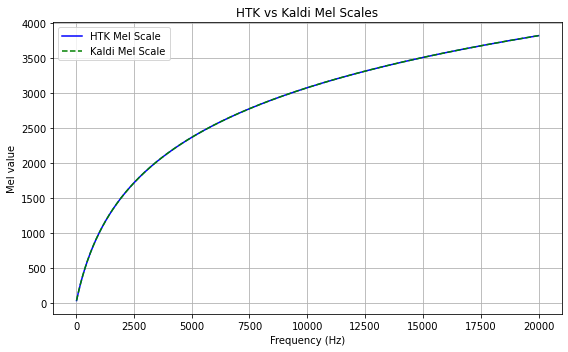

AttributeError: module 'matplotlib' has no attribute 'pyplot'

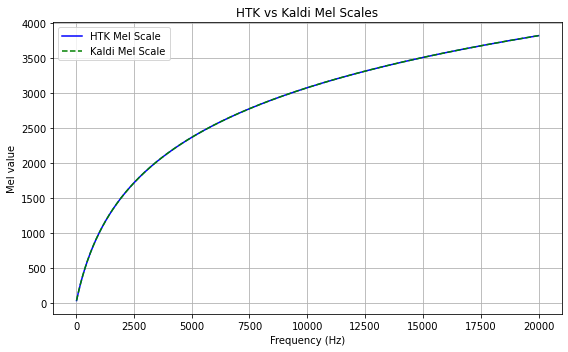

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the frequency range
freqs = np.linspace(20, 20000, 1000)

# HTK Mel scale function
def get_htk_scale(freqs):
    htk_scale = 2595.0 * np.log10(1.0 + (freqs / 700.0))
    return htk_scale

# Kaldi Mel scale function
def get_kaldi_scale(freqs):
    kaldi_scale = 1127.0 * np.log(1.0 + (freqs / 700.0))
    return kaldi_scale

# Compute Mel values
htk_mels = get_htk_scale(freqs)
kaldi_mels = get_kaldi_scale(freqs)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(freqs, htk_mels, label="HTK Mel Scale", color='blue')
plt.plot(freqs, kaldi_mels, label="Kaldi Mel Scale", color='green', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mel value")
plt.title("HTK vs Kaldi Mel Scales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from auditory_cortex.dnn_feature_extractor import create_feature_extractor
feature_extractor = create_feature_extractor('whisper_tiny')

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/processor_config.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://h

In [ ]:
feature_extractor.processor

WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-tiny', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|>', 

In [ ]:
import deepspeech_pytorch.loader.data_loader as data_loader
from deepspeech_pytorch.configs.train_config import SpectConfig

audio_config = SpectConfig()
parser = data_loader.AudioParser(audio_config, normalize=True)

/bin/sh: line 1: sox: command not found
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [ ]:
parser.window

'hamming'

In [ ]:
self.window_stride = audio_conf.window_stride
        self.window_size = audio_conf.window_size
        self.sample_rate = audio_conf.sample_rate
        self.window = audio_conf.window.value
        self.normalize = normalize

In [ ]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)

In [ ]:
sessions = metadata.get_all_available_sessions()
sessions = np.sort(sessions)

In [ ]:
from transformers.utils.import_utils import is_torch_available
is_torch_available()

True

In [ ]:
sessions[34:35]

array(['200206'], dtype='<U6')

In [ ]:
stim_id = 12
mVocs = False
aud = metadata.get_stim_audio(stim_id, mVocs=mVocs)

27392.5

In [ ]:
from scipy.signal import resample
aud = resample(aud, int(aud.size*20/16))

In [ ]:
aud = resample

In [ ]:
from pycochleagram import cochleagram as cgram

spect = cgram.human_cochleagram(
    aud,                # Your 2-second waveform (e.g., a NumPy array of shape (32000,) for 16 kHz)
    sr=20000,           # Sampling rate of the waveform
    n=50,              # Number of filters in the filterbank
    low_lim=50,         # Lower frequency limit in Hz
    hi_lim=10000,       # Upper frequency limit in Hz
    sample_factor=4,    # Determines filter overlap (87.5% overlap for sample_factor=4)
    downsample=None,     # Downsample envelopes to 200 Hz
    nonlinearity='power' # Apply 3/10 power compression to simulate basilar membrane compression
)

here


In [ ]:
spect.shape

(211, 27392)

In [ ]:
spect.transpose().shape

(27392, 211)

In [ ]:
spect = self.dataloader.feature_extractor.process_input(aud)

In [ ]:
from pycochleagram import cochleagram as cgram
n=38 
sample_factor=2 
downsample=None 
nonlinearity=None

signal = aud
sr = 16000
human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity=nonlinearity, strict=False)

here


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:129: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(batch_signal.shape[1],
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


In [ ]:
human_coch.shape

(81, 21914)

In [ ]:
from pycochleagram.demo import demo_human_cochleagram, make_harmonic_stack, demo_human_cochleagram_helper

# demo_human_cochleagram()
signal, signal_params = make_harmonic_stack()
sr = signal_params['sr']
n = signal_params['n']

# coch_pow = demo_human_cochleagram_helper(signal, sr, n, nonlinearity='power')
human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity=nonlinearity, strict=False)

here


In [ ]:
human_coch.shape

(81, 5002)

In [ ]:
coch_pow.shape

(81, 5002)

In [ ]:
signal.shape

(5002,)

here
here
here


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:129: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(batch_signal.shape[1],
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


here
here


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:129: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(batch_signal.shape[1],
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


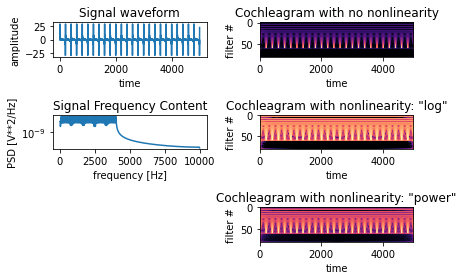

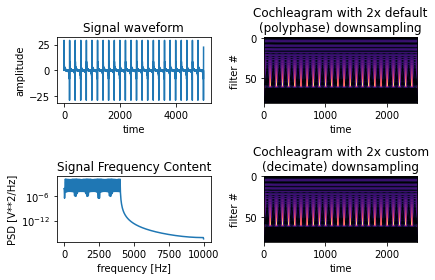

In [ ]:

demo_human_cochleagram()

In [ ]:
signal, signal_params = make_harmonic_stack()
sr = signal_params['sr']
n = signal_params['n']

coch = cgram.human_cochleagram(
    signal,             # Your 2-second waveform (e.g., a NumPy array of shape (40000,))
    sr=sr,           # Sampling rate of the waveform
    n=n,              # Number of filters in the filterbank
    low_lim=30,         # Lower frequency limit in Hz
    hi_lim=7860,        # Upper frequency limit in Hz
    sample_factor=4,    # Determines filter overlap (87.5% overlap for sample_factor=4)
    downsample=None,     # Downsample envelopes to 200 Hz (upsample factor)
    nonlinearity='power' # Apply 3/10 power compression to simulate basilar membrane compression
)

here


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pycochleagram-0.1-py3.8.egg/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


In [ ]:
coch.shape

(163, 5002)

here
here


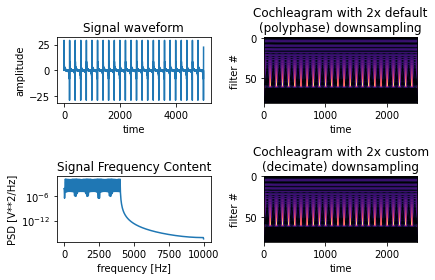

In [ ]:
from pycochleagram import utils
from scipy.signal import welch, decimate
signal, signal_params = make_harmonic_stack()
sr = signal_params['sr']
n = signal_params['n']

plt.figure()
# no downsampling
# cochd = demo_human_cochleagram_helper(signal, sr, n, downsample=None)
# predefined polyphase resampling with upsample factor = 10000, downsample factor = `sr`
cochd_poly = demo_human_cochleagram_helper(signal, sr, n, downsample=10000)
# custom downsampling function to use decimate with a downsampling factor of 2
custom_downsample_fx = lambda x: decimate(x, 2, axis=1, ftype='fir', zero_phase=True)
cochd_decimate = demo_human_cochleagram_helper(signal, sr, n, downsample=custom_downsample_fx)

plt.subplot(221)
plt.title('Signal waveform')
plt.plot(signal)
plt.ylabel('amplitude')
plt.xlabel('time')

plt.subplot(223)
plt.title('Signal Frequency Content')
f, Pxx_den = welch(signal.flatten(), sr, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(222)
plt.title('Cochleagram with 2x default\n(polyphase) downsampling')
plt.ylabel('filter #')
plt.xlabel('time')
utils.cochshow(np.flipud(cochd_poly), interact=False)
plt.gca().invert_yaxis()

plt.subplot(224)
plt.title('Cochleagram with 2x custom\n(decimate) downsampling')
plt.ylabel('filter #')
plt.xlabel('time')
utils.cochshow(np.flipud(cochd_decimate), interact=False)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
n

38

In [ ]:
signal.shape

(5002,)

In [ ]:
cochd_poly.shape

(81, 2501)

In [ ]:
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
%matplotlib inline
from auditory_cortex.analyses import Correlations, STRFCorrelations


INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...


(-0.5, 2.0)

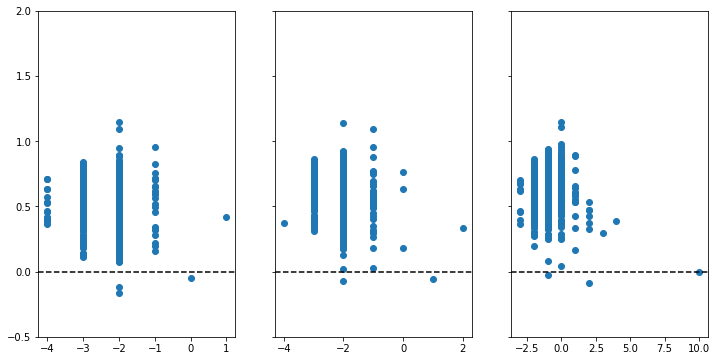

In [ ]:
model_name = 'STRF_freqs80'
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
i = 0
identifier = 'mel_wh_ucsf_mVocs_trf_lags50_bw50_plos_review'
strf_obj = STRFCorrelations(model_name + '_' + identifier)
data = strf_obj.get_highly_tuned_channels(strf_obj.data, threshold=0.5, mVocs=True)
axes[i].scatter(data['lmbda'], data['mVocs_normalized_test_cc'])
axes[i].axhline(0, color='black', linestyle='--')
axes[i].set_ylim(-0.5, 2)
# axes[i].hist(strf_obj.data['lmbda'])
# axes[i].set_xlim(-5, 10)

i=1
identifier = 'mel_wh_ucsf_mVocs_trf_lags300_bw50_naplib_matched'
strf_obj = STRFCorrelations(model_name + '_' + identifier)
data = strf_obj.get_highly_tuned_channels(strf_obj.data, threshold=0.5, mVocs=True)
axes[i].scatter(data['lmbda'], data['mVocs_normalized_test_cc'])
axes[i].axhline(0, color='black', linestyle='--')
axes[i].set_ylim(-0.5, 2)
# axes[i].hist(strf_obj.data['lmbda'])
# axes[i].set_xlim(-5, 10)

i=2
identifier = 'mel_wh_ucsf_mVocs_trf_lags300_bw50_regression_improved'
strf_obj = STRFCorrelations(model_name + '_' + identifier)
data = strf_obj.get_highly_tuned_channels(strf_obj.data, threshold=0.5, mVocs=True)
axes[i].scatter(data['lmbda'], data['mVocs_normalized_test_cc'])
axes[i].axhline(0, color='black', linestyle='--')
axes[i].set_ylim(-0.5, 2)
# axes[i].hist(strf_obj.data['lmbda'])
# axes[i].set_xlim(-5, 10)

In [ ]:
import numpy as np
y_delayed = np.random.randn(100, 64)
y_mean = y_delayed.mean(axis=0, keepdims=True)

In [ ]:
bin_width = 50
mVocs = False
dataset_name = 'ucsf'
model_name = 'whisper_tiny'
mel_spectrogram = False
# spectrogram_type = 'cochleagram'
spectrogram_type = 'wavlet'

metadata = create_neural_metadata(dataset_name)

sessions = metadata.get_all_available_sessions()
sessions = np.sort(sessions)
dataset_obj = create_neural_dataset(dataset_name, sessions[34:35])
whisper_extractor = create_feature_extractor(model_name)

dataset = STRFDataAssembler(
        dataset_obj, bin_width, mVocs=mVocs,
        mel_spectrogram=mel_spectrogram,
        spectrogram_type=spectrogram_type,
        )
dataset.dataloader.dataset_obj.sub

INFO:NeuralData:  Creating object for session: ['200206'] ... 
INFO:Done.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO:Using wavelet-spectrogram for STRF.
INFO:creating Dataset for timit data.
INFO:Loading data for session at bin_width-50ms.


'200206'

In [ ]:
features_list, spikes_list = dataset.get_training_data()

In [ ]:
features_list[0].shape

(43, 80)

In [ ]:
spikes_list[0].shape

(36, 64)

In [ ]:
features_list[0][32]

array([ 0.01715409,  0.02343502,  0.05652982,  0.19219147,  0.67044946,
        0.50992928,  0.19169734,  0.17347509,  0.05776684,  0.06111536,
        0.02302929,  0.0460837 ,  0.02060515,  0.0243281 ,  0.01978111,
        0.02113791,  0.04404908, -0.01898892,  0.41146636,  0.85484914,
        0.47311584,  0.36840761,  0.14807326,  0.16612077,  0.06051785,
        0.11160447,  0.03773496,  0.84543639,  0.93078852,  0.49299516,
        0.2853202 ,  0.04666391,  0.05657386,  0.14416844,  0.34682639,
        0.18527841,  0.16048974,  0.01656877,  0.10959097,  0.11126044,
        0.10578221,  0.07170012,  0.09560091,  0.0914932 ,  0.06329768,
        0.12671277,  0.12390997,  0.01429338,  0.07091272,  0.17876763,
        0.04192121,  0.19691124,  0.13927887,  0.08119807,  0.0679379 ,
        0.05361348,  0.04752062,  0.03657182,  0.04517538,  0.06449996,
        0.09324832,  0.12280609,  0.07086345,  0.04203176,  0.03392404,
        0.03904683,  0.04606055,  0.0290971 ,  0.00906156, -0.03

In [ ]:
spikes_list[0][32]

array([ 0,  0,  2,  0,  0,  0,  2,  1,  1,  1,  1,  0,  2,  0,  0,  2,  2,
        3,  1,  0,  0,  1,  3,  0,  3,  1,  1,  0,  0,  0,  1,  0,  3,  0,
        1,  1,  3,  0,  2,  1,  2,  1,  0,  0,  1,  9,  1,  9,  4,  1,  1,
       23,  8,  3,  3,  8,  2, 10, 21,  7,  1,  0,  3,  3], dtype=int32)

In [ ]:
dataset_obj = create_neural_dataset(dataset_name, sessions[4])
dataset.read_session_spikes(dataset_obj)
dataset.dataloader.dataset_obj.sub

INFO:NeuralData:  Creating object for session: 180613 ... 
INFO:Done.
INFO:Loading data for session at bin_width-50ms.


'180613'

In [ ]:
dataset_obj = create_neural_dataset(dataset_name, sessions[5])
dataset.read_session_spikes(dataset_obj)
print(dataset.num_channels)
dataset.dataloader.dataset_obj.sub

INFO:NeuralData:  Creating object for session: 180622 ... 
INFO:Done.
INFO:Loading data for session at bin_width-50ms.
16


'180622'

In [ ]:
dataset.num_channels

16

In [ ]:
features_list, spikes_list = dataset.get_training_data()

In [ ]:
spikes_list[0].shape

(36, 16)

In [ ]:
features_list[0][32]

array([ 0.01715409,  0.02343502,  0.05652982,  0.19219147,  0.67044946,
        0.50992928,  0.19169734,  0.17347509,  0.05776684,  0.06111536,
        0.02302929,  0.0460837 ,  0.02060515,  0.0243281 ,  0.01978111,
        0.02113791,  0.04404908, -0.01898892,  0.41146636,  0.85484914,
        0.47311584,  0.36840761,  0.14807326,  0.16612077,  0.06051785,
        0.11160447,  0.03773496,  0.84543639,  0.93078852,  0.49299516,
        0.2853202 ,  0.04666391,  0.05657386,  0.14416844,  0.34682639,
        0.18527841,  0.16048974,  0.01656877,  0.10959097,  0.11126044,
        0.10578221,  0.07170012,  0.09560091,  0.0914932 ,  0.06329768,
        0.12671277,  0.12390997,  0.01429338,  0.07091272,  0.17876763,
        0.04192121,  0.19691124,  0.13927887,  0.08119807,  0.0679379 ,
        0.05361348,  0.04752062,  0.03657182,  0.04517538,  0.06449996,
        0.09324832,  0.12280609,  0.07086345,  0.04203176,  0.03392404,
        0.03904683,  0.04606055,  0.0290971 ,  0.00906156, -0.03

In [ ]:
spikes_list[0][32]

array([0, 0, 0, 0, 0, 0, 1, 3, 0, 3, 1, 0, 0, 1, 0, 0], dtype=int32)

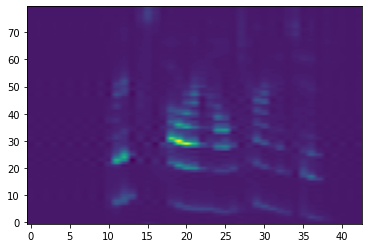

In [ ]:
plt.imshow(features_list[0].T, aspect='auto', origin='lower')

In [ ]:
layer_ID = 2
bin_width = 50
mVocs = False
dataset_name = 'ucsf'
model_name = 'whisper_tiny'
metadata = create_neural_metadata(dataset_name)

sessions = metadata.get_all_available_sessions()
sessions = np.sort(sessions)
whisper_extractor = create_feature_extractor(model_name)
dataset_obj = create_neural_dataset(dataset_name, sessions[34:35])

dataset = DNNDataAssembler(
    dataset_obj, whisper_extractor, layer_ID, bin_width=bin_width, mVocs=mVocs,
    LPF=True
    )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO:NeuralData:  Creating object for session: ['200206'] ... 
INFO:Done.
INFO:creating Dataset for LPF features, to predict at 20ms.
INFO:creating Dataset for timit data.
INFO:Loading data for session at bin_width-20ms.
INFO:Reading features for model: whisper_tiny
INFO:Resamping ANN features at bin-width: 50
INFO:Resampled ANN features at LPF bin-width: 20


In [ ]:
dataset.data_cache['testing_spikes'][12][32].shape

(11, 68)

In [ ]:
spikes = dataset.dataloader.get_session_spikes(repeated=True)

In [ ]:
all_trial_spikes = np.stack([spikes[12][ch] for ch in spikes[12].keys()], axis=-1)

In [ ]:
all_trial_spikes.shape

(11, 27, 64)

In [ ]:
dataset.dataloader.get_testing_stim_ids()

array([ 12,  13,  32,  43,  56, 163, 212, 218, 287, 308])

In [ ]:
aud = dataset.dataloader.get_stim_audio(12)

In [ ]:
features_list, spikes_list = dataset.get_training_data()

In [ ]:
features_list[0].shape

(109, 384)

In [ ]:
spikes_list[0].shape

(91, 64)

In [ ]:
dataset.n_offset

18

In [ ]:
dataset.dataloader.calculate_num_bins(0.35, bin_width/1000)

7

In [ ]:
np.logspace(-1, 15, 17)

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14,
       1.e+15])

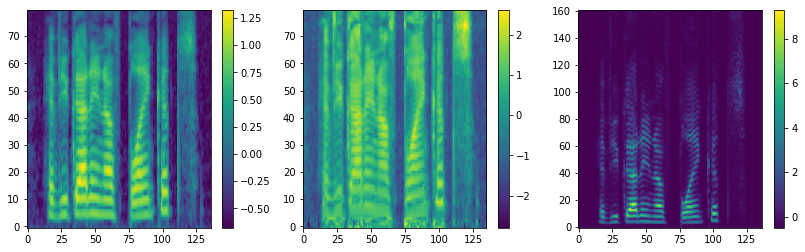

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
i=0
wh_spect = whisper_extractor.process_input(aud)
cax = axes[i].imshow(wh_spect.transpose(), origin='lower', aspect='auto')
plt.colorbar(mappable=cax, ax=axes[i])

i=1
st_spect = speech2text_extractor.process_input(aud)
cax = axes[i].imshow(st_spect.transpose(), origin='lower', aspect='auto')
plt.colorbar(mappable=cax, ax=axes[i])

i=2
st_spect = deepspeech2_extractor.process_input(aud)
cax = axes[i].imshow(st_spect.transpose(), origin='lower', aspect='auto')
plt.colorbar(mappable=cax, ax=axes[i])

In [ ]:
stim_id = 12
mVocs = False
bin_width = 50
aud = dataset.dataloader.get_stim_audio(stim_id, mVocs=mVocs)


In [ ]:
sampling_rate = dataset.dataloader.get_sampling_rate(mVocs=mVocs)
dataset.dataloader.pad_time

0.35

In [ ]:

stim_duration = dataset.dataloader.get_stim_duration(stim_id, mVocs=mVocs)

padding = np.zeros((int(dataset.dataloader.pad_time*sampling_rate)))
aud = np.concatenate((padding, aud))
stim_duration += dataset.dataloader.pad_time

num_bins = dataset.dataloader.calculate_num_bins(stim_duration, bin_width/1000)

AttributeError: 'DataLoader' object has no attribute 'calculate_num_bins'

In [ ]:
padding.shape

(5600,)

In [ ]:

spect = self.get_spectrogram(aud, sampling_rate)
spect = resample(spect, self.num_freqs, axis=1)

# with torch.no_grad():
#     spect = torch.from_numpy(spect).float()
#     spect = self.linear_stack(spect).numpy()
# # spect = np.dot(spect, self.rand_mat) + self.rand_bias

spect = resample(spect, num_bins, axis=0)

In [ ]:
trf_obj = TRF(model_name, dataset)

In [ ]:
features_list, spikes_list = dataset.get_training_data()

INFO:GpuTRF object created with alpha=0.1, tmin=0, tmax=0.29, sfreq=20


In [ ]:
int(sfreq*tmax)

5

In [ ]:
from auditory_cortex.encoding import GpuTRF
lag = 1
tmin = 0
tmax = lag / 1000
sfreq = 20
lmbda = 0.1
trf_model = GpuTRF(
                tmin, tmax, sfreq, alpha=lmbda,
                )

xx = np.zeros((44, 1))
yy = np.zeros((44, 32))
X_tmp, y_tmp = trf_model._delay_and_reshape(xx, yy)
X_tmp.shape

INFO:GpuTRF object created with alpha=0.1, tmin=0, tmax=0.001, sfreq=20


(44, 1)

In [ ]:
trf_model.tmax

0.01

In [ ]:
xx.shape

(44, 10)

(44, 70)

In [ ]:
y_tmp.shape

(36, 64)

In [ ]:
features_list[0].shape

(43, 384)

In [ ]:
spikes_list[0].shape

(36, 64)

In [ ]:
sessions = sessions[args.start_ind:args.end_ind]

In [ ]:
feature_extractor = create_feature_extractor('deepspeech2')

INFO:Lightning automatically upgraded your loaded checkpoint from v1.1.5 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../depot/jgmakin/data/auditory_cortex/results/pretrained_weights/deepspeech2/librispeech_pretrained_v3.ckpt`


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:203: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend s

In [ ]:
audio = np.concatenate([np.zeros((1000, )), np.ones((15000, ))])
stim_audios = {
    1: audio,
}
stim_durations = {
    1: 1,
}
pad_time = 0.35
sampling_rate = 16000

In [ ]:
features = feature_extractor.extract_features(stim_audios, sampling_rate, stim_durations, pad_time)

Padding audio by 0.35 seconds...


In [ ]:
features[0][1].shape

torch.Size([68, 2592])

In [ ]:
mVocs = True
stim_ids = metadata.get_training_stim_ids(mVocs)
stim_durations = []
for stim_id in stim_ids:
    stim_durations.append(metadata.get_stim_duration(stim_id, mVocs))
min(stim_durations), max(stim_durations), np.mean(stim_durations), np.std(stim_durations)

(0.3666875, 3.47475, 1.190746138211382, 0.7099949477450535)

In [ ]:
mVocs = False
stim_ids = metadata.get_training_stim_ids(mVocs)
stim_durations = []
for stim_id in stim_ids:
    stim_durations.append(metadata.get_stim_duration(stim_id, mVocs))
min(stim_durations), max(stim_durations), np.mean(stim_durations), np.std(stim_durations)

(0.985625, 2.592, 2.056310455010225, 0.38664490714018696)

In [ ]:
sessions

array(['180413', '180420', '180501', '180502', '180613', '180622',
       '180627', '180717', '180719', '180720', '180724', '180728',
       '180730', '180731', '180807', '180808', '180810', '180814',
       '190604', '190605', '190606', '190703', '190726', '190801',
       '191113', '191115', '191121', '191125', '191206', '191209',
       '191210', '191211', '191219', '200205', '200206', '200207',
       '200212', '200213', '200219', '200313', '200318'], dtype='<U6')

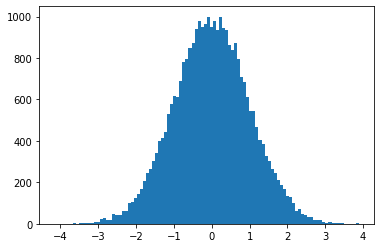

In [ ]:
rand_mat = np.random.randn(80, 384)

plt.hist(rand_mat.flatten(), bins=100)
plt.show()

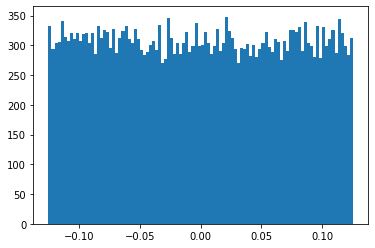

In [ ]:
rand_mat = 0.25*np.random.rand(80, 384) - 0.125

plt.hist(rand_mat.flatten(), bins=100)
plt.show()

In [ ]:
lin_layer = torch.nn.Linear(80, 384)
rand_mat = lin_layer.weight.detach().numpy().T
rand_bias = lin_layer.bias.detach().numpy()

a = np.random.randn(100, 80)
out = np.dot(a, rand_mat) + rand_bias
out.shape

In [ ]:
import math
in_features = 80
k = 1/in_features
a = math.sqrt(k)
print(a)
rand_mat = np.random.uniform(-a, a, (80, 384))
rand_mat.shape

0.11180339887498948


(80, 384)

In [ ]:
math.sqrt(k)

0.11180339887498948

In [ ]:
math.sqrt(in_features)

8.94427190999916

In [ ]:
rand_mat.shape

(80, 384)

In [ ]:
rand_bias.shape

(384,)

(100, 384)

In [ ]:
a = torch.rand(80, 384)
xav = torch.nn.init.xavier_uniform_(a.T)
rand_mat = xav.T.data.numpy()
rand_mat.shape

(80, 384)

(1, 384)


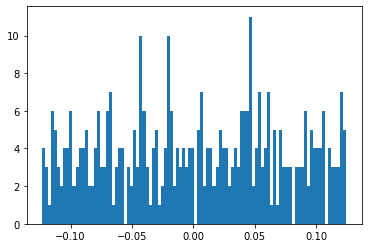

In [ ]:
dim1 = 1
dim2 = 384
a = np.sqrt(6/(dim2+dim1))
rand_mat = np.random.uniform(-a, a, (dim1, dim2))
print(rand_mat.shape)
plt.hist(rand_mat.flatten(), bins=100)
plt.show()


(80, 384)


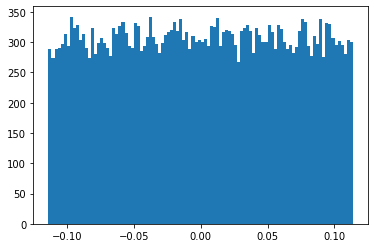

In [ ]:
dim1 = 80
dim2 = 384
a = np.sqrt(6/(dim2+dim1))
rand_mat = np.random.uniform(-a, a, (dim1, dim2))
print(rand_mat.shape)
plt.hist(rand_mat.flatten(), bins=100)
plt.show()

In [ ]:
b = torch.rand(384,)
xav_b = torch.nn.init.kaiming_uniform_(b)


ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions

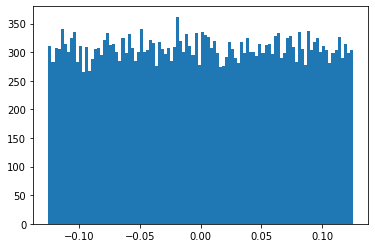

In [ ]:
a = torch.randn(80, 384)
xav = torch.nn.init.kaiming_uniform_(a)
plt.hist(xav.data.numpy().flatten(), bins=100)
plt.show()

In [ ]:
model_name = 'whisper_tiny'
feature_extractor = create_feature_extractor(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
aud = np.random.randn(16000,)  # Example audio input
spect = feature_extractor.process_input(aud)
spect.shape

(100, 80)

In [ ]:
spect = np.random.randn(100, 80)
rand_mat = np.random.randn(80, 384)

mod_spect = np.dot(spect, rand_mat)
mod_spect.shape

(100, 384)

In [ ]:
model_name = 'speech2text'
feature_extractor = create_feature_extractor(model_name)

Some weights of Speech2TextForConditionalGeneration were not initialized from the model checkpoint at facebook/s2t-large-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
aud = np.random.randn(16000,)  # Example audio input
spect = feature_extractor.process_input(aud)
spect.shape

(98, 80)

In [ ]:
model_name = 'deepspeech2'
feature_extractor = create_feature_extractor(model_name)

INFO:Lightning automatically upgraded your loaded checkpoint from v1.1.5 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../depot/jgmakin/data/auditory_cortex/results/pretrained_weights/deepspeech2/librispeech_pretrained_v3.ckpt`


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:203: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend s

In [ ]:
aud = np.random.randn(16000,)  # Example audio input
spect = feature_extractor.process_input(aud)
spect.shape

(101, 161)

In [ ]:
import pickle
from auditory_cortex import neural_data_dir, config, NEURAL_DATASETS
DATASET_NAME = NEURAL_DATASETS[0]
DATA_DIR = os.path.join(neural_data_dir, DATASET_NAME)
filename = 'mVoc_stim_details.pkl'
mVoc_filepath = os.path.join(DATA_DIR, filename)

if os.path.exists(mVoc_filepath):
    with open(mVoc_filepath, 'rb') as F:
        mVoc_stim_dict = pickle.load(F)


In [ ]:
metadata.nid_to_tr_id(5)[:1]

array([5])

In [ ]:
metadata.get_testing_stim_ids(True)

array([ 6,  8, 11, 14, 23, 28, 29, 33, 47, 48, 51])

In [ ]:
for stim_id in metadata.mVoc_test_stimIds:
    tr_ids = metadata.mVocId_to_trialId[stim_id]
    print(f"stim_id: {stim_id}, tr_ids: {tr_ids}")

stim_id: 7, tr_ids: [  6  75 111 182 225 296 352 364 450 496 524 610 642 686 754]
stim_id: 9, tr_ids: [  8 101 104 159 209 274 346 377 428 491 553 585 630 689 741]
stim_id: 12, tr_ids: [ 11  91 130 163 231 290 338 375 445 503 526 614 633 710 746]
stim_id: 15, tr_ids: [ 14  60 132 190 230 260 335 398 461 506 532 603 660 702 765]
stim_id: 24, tr_ids: [ 23 103 129 175 220 287 351 373 437 516 556 587 673 681 735]
stim_id: 29, tr_ids: [ 28  58 121 206 235 286 326 380 455 515 522 617 666 721 764]
stim_id: 30, tr_ids: [ 29  65 138 173 250 297 355 385 422 478 549 578 655 677 767]
stim_id: 33, tr_ids: [ 33  90 131 164 242 310 315 379 447 489 559 574 638 716 734]
stim_id: 44, tr_ids: [ 47  78 143 162 215 284 320 412 452 500 520 577 671 705 758]
stim_id: 45, tr_ids: [ 48  98 110 170 222 263 337 391 435 498 531 596 641 700 748]
stim_id: 48, tr_ids: [ 51  73 117 205 254 262 317 366 460 488 565 602 656 694 728]


In [ ]:
nid = 6
result = next(
        ((k, v) for k, v in metadata.mVocId_to_trialId.items() if nid in v),    # only for test nids
            None)


In [ ]:
result

(7,
 array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
        686, 754]))

In [ ]:
k, v = result
if v.size ==15:
    print(v)

In [ ]:
v.size

2

In [ ]:
metadata.mVocId_to_trialId[7]

array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
       686, 754])

In [ ]:
metadata.total_stimuli_duration()

{'unique': 1005.5358125000007, 'repeated': 16.550687500000002}

In [ ]:
metadata.total_stimuli_duration(True)

{'unique': 290.20224999999976, 'repeated': 11.265749999999999}

In [ ]:
metadata.get_total_test_duration(True)

16.550687500000002

In [ ]:
metadata.get_total_test_duration(True)

11.265749999999999

In [ ]:
metadata.get_testing_stim_ids(True).shape

(11,)

In [ ]:
metadata.get_training_stim_ids(True).shape

(292,)

In [ ]:
tr_id = self.get_mVoc_tr_id(stim_id)[0]

In [ ]:
mVocs_all_stim_ids = np.array(metadata.mVocs_all_stim_ids)
test_stim_ids = np.array(self.mVoc_test_stimIds)
return mVocs_all_stim_ids[np.isin(mVocs_all_stim_ids, test_stim_ids, invert=True)]

In [ ]:
all_trials = metadata.mVocTrialIds
test_trial_ids = np.concatenate([metadata.get_mVoc_tr_id(stim_id) for stim_id in metadata.mVoc_test_stimIds])
train_nids = all_trials[np.isin(all_trials, test_trial_ids, invert=True)]

In [ ]:
metadata.mVocId_to_trialId

{1: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 2: array([1]),
 3: array([  2,  68, 105, 145, 187, 229, 294, 350, 413, 419, 470, 534, 601,
        674, 690, 768]),
 4: array([  3, 567]),
 5: array([4]),
 6: array([  5,  59, 154, 156, 167, 259, 289, 345, 405, 424, 508, 535, 591,
        652, 682, 697, 745]),
 7: array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
        686, 754]),
 8: array([  7, 563]),
 9: array([  8, 101, 104, 159, 209, 274, 346, 377, 428, 491, 553, 585, 630,
        689, 741]),
 10: array([  9, 423, 623]),
 11: array([ 10,  87, 108, 186, 210, 252, 307, 318, 371, 441, 507, 554, 564,
        592, 667, 720, 773]),
 12: array([ 11,  91, 130, 163, 231, 290, 338, 375, 445, 503, 526, 614, 633,
        710, 746]),
 13: array([ 12, 410, 676]),
 14: array([13]),
 15: array([ 14,  60, 132, 190, 230, 260, 335, 398, 461, 506, 532, 603, 660,
        702, 765]),
 16: array([15]),
 17: array([

In [ ]:
nid = 6
for k,v in metadata.mVocId_to_trialId.items():
    if nid in v:
        print(k)
        break

7


In [ ]:
k = next((k for k, v in mVocId_to_trialId.items() if nid in v), None)

In [ ]:
train_nids.shape

(615,)

In [ ]:
test_trial_ids = np.array([metadata.get_mVoc_tr_id(stim_id)[0] for stim_id in metadata.mVoc_test_stimIds])

In [ ]:
test_trial_ids

array([ 6,  8, 11, 14, 23, 28, 29, 33, 47, 48, 51])

In [ ]:
test_trial_ids.shape

(165,)

In [ ]:
metadata.mVoc_test_stimIds

[7, 9, 12, 15, 24, 29, 30, 33, 44, 45, 48]

In [ ]:
metadata.get_mVoc_tr_id(7)

array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
       686, 754])

In [ ]:
mVoc_stim_dict['stim_audios'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [ ]:
from auditory_cortex.neural_data.deprecated.dataset import NeuralData
session = '180501'
dataset = NeuralData(session)

NeuralData:  Creating object for session: 180501 ... Done.


In [ ]:
mVocstimCodes = np.unique(dataset.spikes[0].mVocStimcode)
# mVocstimCodes
trial_ids = []
# excluding trial id=0
for mVocs in mVocstimCodes[1:]:
    trials = dataset.get_mVocs_trials(mVocs)
    trial_ids.extend(list(trials))

In [ ]:
trial_ids.sort()
mVocs_first_tr = np.min(trial_ids)

trial_ids = trial_ids - mVocs_first_tr

In [ ]:
trial_ids.shape

(1290,)

In [ ]:
np.max(trial_ids)

1559

In [ ]:
all_trial_ids = np.arange(780)
missing_trial_ids = all_trial_ids[np.isin(all_trial_ids, trial_ids,invert=True)]

In [ ]:
missing_trial_ids.shape

(135,)

In [ ]:
mVocs = 303

trials = (np.where(dataset.trials[0].mVocStimcode == mVocs)[0]) + 1 # matlab to python indexing
trials 

array([1332, 2112])

In [ ]:
spikes = dataset.extract_mVocs_spikes(50)

NeuralData: Reading mVocs spikes for 180501. 


In [ ]:
np.unique(list(spikes.keys())).shape

(645,)

In [ ]:
stim_ids = dataset.metadata.mVocTrialIds
missing_trial_ids = dataset.missing_trial_ids
stim_ids = stim_ids[np.isin(stim_ids, missing_trial_ids, invert=True)]
test_ids = dataset.metadata.mVoc_test_trIds
training_stim_ids = stim_ids[np.isin(stim_ids, test_ids, invert=True)]
all_trial_ids = stim_ids

In [ ]:
session_ids = all_trial_ids + dataset.mVocs_first_tr

In [ ]:
session_ids

array([ 553,  554,  555,  556,  557,  558,  559,  560,  561,  562,  563,
        564,  565,  567,  569,  570,  571,  572,  573,  574,  575,  576,
        577,  578,  579,  580,  581,  582,  584,  585,  586,  588,  590,
        591,  593,  594,  595,  596,  597,  598,  599,  600,  601,  602,
        603,  604,  605,  606,  610,  611,  612,  613,  615,  616,  617,
        618,  619,  620,  621,  622,  625,  626,  627,  628,  629,  630,
        631,  632,  635,  637,  638,  639,  640,  643,  644,  646,  647,
        648,  649,  650,  651,  652,  653,  654,  655,  656,  657,  658,
        660,  661,  662,  663,  664,  665,  666,  668,  669,  670,  671,
        672,  673,  674,  675,  679,  680,  681,  682,  683,  684,  685,
        686,  687,  688,  689,  690,  691,  692,  693,  694,  696,  698,
        700,  701,  702,  706,  707,  708,  709,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  722,  723,  726,  728,  729,
        730,  731,  732,  733,  734,  735,  736,  7

In [ ]:
mVocs_stim_ids = []
for tr_id in session_ids:
    mVocs_stim_ids.append(dataset.trials[0].mVocStimcode[tr_id-1])


In [ ]:
mVocs_stim_ids = np.unique(mVocs_stim_ids)

In [ ]:
mVocs_stim_ids.shape

(175,)

In [ ]:
dataset.trials[0].timitStimcode[552]

0

In [ ]:
dataset.trials[0].mVocStimcode[552]

1

In [ ]:
dataset.trials[0].mVocStimcode[565]

14

In [ ]:
trial = 13
# map trial Id [0, 779] to session specific trial Id.. 
sess_trial = dataset.mVocs_first_tr + trial
print('session trial:', sess_trial)
# #get 'relative' spike times for the given trial
s_times = dataset.retrieve_spike_times(trial=sess_trial)
#return spikes count in each bin
# output = NeuralData.bin_spike_times(s_times, duration, win=win, delay=delay)

session trial: 566


In [ ]:
s_times

{0: array([], dtype=float64),
 1: array([], dtype=float64),
 2: array([0.32575, 0.3258 , 0.9056 , 1.03265, 1.81205]),
 3: array([], dtype=float64),
 4: array([], dtype=float64),
 5: array([], dtype=float64),
 6: array([], dtype=float64),
 7: array([0.234  , 1.22365, 1.2807 ]),
 8: array([], dtype=float64),
 9: array([], dtype=float64),
 10: array([], dtype=float64),
 11: array([], dtype=float64),
 12: array([], dtype=float64),
 13: array([], dtype=float64),
 14: array([], dtype=float64),
 15: array([], dtype=float64)}

In [ ]:
dir(dataset.trials[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fieldnames',
 'amStimcode',
 'dmrStimcode',
 'fmStimcode',
 'mVocStimcode',
 'stimon',
 'timitStimcode']

In [ ]:
from auditory_cortex.neural_data import create_neural_dataset, create_neural_metadata
from auditory_cortex.dnn_feature_extractor import create_feature_extractor
from auditory_cortex.data_assembler import STRFDataAssembler, DNNDataAssembler
from auditory_cortex.encoding import TRF

dataset_name = 'ucsf'
session = 180501
layer_ID = 1
bin_width = 50
mVocs = True
model_name = 'whisper_tiny'
shuffled = False

feature_extractor = create_feature_extractor(model_name, shuffled=shuffled)
dataset_obj = create_neural_dataset(dataset_name, session)
data_assembler = DNNDataAssembler(
    dataset_obj, feature_extractor, layer_ID, bin_width=bin_width, mVocs=mVocs,
    )

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


/bin/sh: line 1: sox: command not found
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO:auditory_cortex.neural_data.ucsf_data.ucsf_dataset:NeuralData:  Creating object for session: 180501 ... 
INFO:auditory_cortex.neural_data.ucsf_data.ucsf_dataset:Done.
INFO:auditory_cortex.data_assembler:creating Dataset for mVocs data.
INFO:auditory_cortex.data_assembler:Loading data for session at bin_width-50ms.
INFO:auditory_cortex.io_utils.io:Reading features for model: whisper_tiny
INFO:auditory_cortex.dataloader2:Resamping ANN features at bin-width: 50


In [ ]:
data_assembler.testing_stim_ids

array([ 6,  8, 11, 14, 23, 28, 29, 33, 47, 48, 51])

In [ ]:
data_assembler.data_cache['testing_spikes'].keys()

dict_keys([6, 8, 11, 14, 23, 28, 29, 33, 47, 48, 51])

In [ ]:
data_assembler.training_stim_ids

array([  0,   1,   2,   3,   4,   5,   7,   9,  10,  12,  13,  15,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  30,  31,  32,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        49,  50,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  64,
        66,  67,  68,  69,  70,  71,  72,  74,  76,  77,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  92,  93,  94,  95,  96,
        97,  99, 100, 102, 105, 106, 107, 108, 109, 112, 113, 114, 115,
       116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 133, 134,
       135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 165, 166,
       167, 168, 169, 171, 172, 174, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 207, 208, 210, 211, 212, 213,
       214, 216, 217, 218, 219, 221, 223, 224, 226, 227, 228, 22

In [ ]:
data_assembler.data_cache['training_spikes'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 31, 32, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 49, 50, 52, 53, 57, 59, 62, 63, 64, 66, 67, 68, 69, 72, 74, 76, 77, 79, 82, 84, 85, 86, 87, 93, 94, 95, 96, 97, 99, 100, 102, 105, 107, 108, 109, 112, 113, 115, 116, 118, 119, 120, 122, 126, 127, 128, 133, 134, 135, 136, 137, 139, 140, 141, 145, 147, 148, 149, 153, 154, 155, 156, 158, 160, 161, 165, 166, 167, 169, 176, 177, 178, 179, 180, 181, 183, 184, 186, 187, 188, 189, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 208, 210, 211, 213, 214, 216, 217, 218, 219, 221, 224, 226, 227, 228, 229, 232, 233, 234, 236, 237, 238, 240, 241, 244, 245, 246, 248, 249, 251, 252, 253, 255, 256, 258, 259, 261, 264, 265, 266, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 283, 285, 289, 291, 292, 293, 294, 295, 299, 300, 301, 304, 307, 308, 309, 311, 312, 314, 316, 318, 321, 322, 324, 327, 330, 331, 332, 333, 334, 336, 341, 342, 343, 344, 345,

In [ ]:
bin_width = 50
mVocs = True
repeated = False
delay=0

In [ ]:
if mVocs:
    get_trial_ids = dataset_obj.metadata.nid_to_tr_id
    get_spike_counts = dataset_obj.retrieve_mVocs_spike_counts
else:
    get_trial_ids = dataset_obj.get_trials
    get_spike_counts = dataset_obj.retrieve_spike_counts

stim_group = 'repeated' if repeated else 'unique'
stim_ids = dataset_obj.get_stim_ids(mVocs=mVocs)[stim_group]
spikes = {}


In [ ]:
dataset_obj.missing_trial_ids

array([ 13,  15,  30,  34,  36,  39,  54,  55,  56,  61,  70,  71,  80,
        81,  83,  88,  89,  92, 106, 114, 123, 124, 125, 142, 144, 146,
       150, 151, 152, 157, 168, 171, 172, 174, 185, 192, 203, 207, 212,
       223, 239, 243, 247, 257, 267, 268, 282, 288, 298, 302, 303, 305,
       306, 313, 319, 323, 325, 328, 329, 339, 340, 347, 348, 365, 367,
       370, 374, 383, 387, 388, 389, 394, 395, 399, 406, 414, 425, 433,
       440, 442, 454, 458, 459, 465, 471, 472, 473, 480, 481, 482, 483,
       484, 499, 504, 505, 529, 539, 544, 546, 547, 548, 555, 557, 570,
       576, 590, 593, 605, 613, 615, 620, 622, 625, 631, 643, 647, 654,
       659, 663, 672, 675, 684, 696, 707, 709, 717, 718, 719, 724, 725,
       740, 771, 772, 777, 778])

In [ ]:
stim_ids

array([  0,   1,   2,   3,   4,   5,   7,   9,  10,  12,  13,  15,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  30,  31,  32,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        49,  50,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  64,
        66,  67,  68,  69,  70,  71,  72,  74,  76,  77,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  92,  93,  94,  95,  96,
        97,  99, 100, 102, 105, 106, 107, 108, 109, 112, 113, 114, 115,
       116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 133, 134,
       135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 165, 166,
       167, 168, 169, 171, 172, 174, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 207, 208, 210, 211, 212, 213,
       214, 216, 217, 218, 219, 221, 223, 224, 226, 227, 228, 22

In [ ]:
stim_id = stim_ids[0]
tr_ids = get_trial_ids(stim_id)
if not repeated:
    # only one trial for unique stimuli
    tr_ids = tr_ids[:1]

all_tr_spikes = []
for tr_id in tr_ids:
    # if mVocs:
    #     tr_id = tr_id + dataset_obj.mVocs_first_tr
    tr_spikes = get_spike_counts(trial=tr_id, win=bin_width, delay=delay)
    all_tr_spikes.append(tr_spikes)

In [ ]:
tr_id

859

In [ ]:
for stim_id in stim_ids:
    tr_ids = get_trial_ids(stim_id)
    if not repeated:
        # only one trial for unique stimuli
        tr_ids = tr_ids[:1]

    all_tr_spikes = []
    for tr_id in tr_ids:
        if mVocs:
            tr_id = tr_id + self.mVocs_first_tr
        tr_spikes = get_spike_counts(trial=tr_id, win=bin_width, delay=delay)
        all_tr_spikes.append(tr_spikes)

    num_channels = len(all_tr_spikes[0])
    all_ch_spikes_dict = {}
    for ch in range(num_channels):
        channel_spikes = [tr_spikes[ch] for tr_spikes in all_tr_spikes]
        channel_spikes = np.stack(channel_spikes, axis=0)
        all_ch_spikes_dict[ch] = channel_spikes

    spikes[stim_id] = all_ch_spikes_dict
return spikes

In [ ]:
spikes = dataset_obj.extract_spikes(50, repeated=False, mVocs=True)

In [ ]:
spikes.keys()

dict_keys([6, 8, 11, 14, 23, 28, 29, 33, 47, 48, 51])

In [ ]:
spikes[6][0].shape

(15, 16)

In [ ]:
train_x, train_y = data_assembler.get_training_data()
test_x, test_y = data_assembler.get_testing_data()

In [ ]:
len(train_x)

489

In [ ]:
train_x[0].shape

(36, 384)

In [ ]:
train_y[0].shape

(36, 64)

In [ ]:
len(test_x)

10

In [ ]:
test_x[0].shape

(27, 384)

In [ ]:
test_y[0].shape

(11, 27, 64)

In [ ]:
data_assembler.training_stim_ids

In [ ]:
spikes = dataset_obj.extract_spikes(bin_width=bin_width, mVocs=mVocs)

In [ ]:
dataset_obj.missing_trial_ids

array([ 13,  15,  30,  34,  36,  39,  54,  55,  56,  61,  70,  71,  80,
        81,  83,  88,  89,  92, 106, 114, 123, 124, 125, 142, 144, 146,
       150, 151, 152, 157, 168, 171, 172, 174, 185, 192, 203, 207, 212,
       223, 239, 243, 247, 257, 267, 268, 282, 288, 298, 302, 303, 305,
       306, 313, 319, 323, 325, 328, 329, 339, 340, 347, 348, 365, 367,
       370, 374, 383, 387, 388, 389, 394, 395, 399, 406, 414, 425, 433,
       440, 442, 454, 458, 459, 465, 471, 472, 473, 480, 481, 482, 483,
       484, 499, 504, 505, 529, 539, 544, 546, 547, 548, 555, 557, 570,
       576, 590, 593, 605, 613, 615, 620, 622, 625, 631, 643, 647, 654,
       659, 663, 672, 675, 684, 696, 707, 709, 717, 718, 719, 724, 725,
       740, 771, 772, 777, 778])

In [ ]:
dataset_obj.metadata.mVocId_to_trialId

{1: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 2: array([1]),
 3: array([  2,  68, 105, 145, 187, 229, 294, 350, 413, 419, 470, 534, 601,
        674, 690, 768]),
 4: array([  3, 567]),
 5: array([4]),
 6: array([  5,  59, 154, 156, 167, 259, 289, 345, 405, 424, 508, 535, 591,
        652, 682, 697, 745]),
 7: array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
        686, 754]),
 8: array([  7, 563]),
 9: array([  8, 101, 104, 159, 209, 274, 346, 377, 428, 491, 553, 585, 630,
        689, 741]),
 10: array([  9, 423, 623]),
 11: array([ 10,  87, 108, 186, 210, 252, 307, 318, 371, 441, 507, 554, 564,
        592, 667, 720, 773]),
 12: array([ 11,  91, 130, 163, 231, 290, 338, 375, 445, 503, 526, 614, 633,
        710, 746]),
 13: array([ 12, 410, 676]),
 14: array([13]),
 15: array([ 14,  60, 132, 190, 230, 260, 335, 398, 461, 506, 532, 603, 660,
        702, 765]),
 16: array([15]),
 17: array([

In [ ]:
# if mVocs:
#     get_trial_ids = self.metadata.get_mVoc_tr_id
#     get_spike_counts = self.retrieve_mVocs_spike_counts
# else:
#     get_trial_ids = self.get_trials
#     get_spike_counts = self.retrieve_spike_counts
repeated =False
stim_group = 'repeated' if repeated else 'unique'
stim_ids = dataset_obj.get_stim_ids(mVocs=mVocs)[stim_group]
spikes = {}


In [ ]:
stim_id = stim_ids[0]
tr_ids = dataset_obj.metadata.get_mVoc_tr_id(stim_id)
if not repeated:
    # only one trial for unique stimuli
    tr_ids = tr_ids[:1]

all_tr_spikes = []

In [ ]:
for stim_id in np.arange(1, 15):
    tr_ids = dataset_obj.metadata.get_mVoc_tr_id(stim_id)
    print(f"stimulus {stim_id}, tr_ids {tr_ids}")
    
# dataset_obj.metadata.get_mVoc_tr_id(14)

stimulus 1, tr_ids [  0  32  95 107 195 227 232 277 356 403 434 490 502 568 575 658 683 715
 770]
stimulus 2, tr_ids [1]
stimulus 3, tr_ids [  2  68 105 145 187 229 294 350 413 419 470 534 601 674 690 768]
stimulus 4, tr_ids [  3 567]
stimulus 5, tr_ids [4]
stimulus 6, tr_ids [  5  59 154 156 167 259 289 345 405 424 508 535 591 652 682 697 745]
stimulus 7, tr_ids [  6  75 111 182 225 296 352 364 450 496 524 610 642 686 754]
stimulus 8, tr_ids [  7 563]
stimulus 9, tr_ids [  8 101 104 159 209 274 346 377 428 491 553 585 630 689 741]
stimulus 10, tr_ids [  9 423 623]
stimulus 11, tr_ids [ 10  87 108 186 210 252 307 318 371 441 507 554 564 592 667 720 773]
stimulus 12, tr_ids [ 11  91 130 163 231 290 338 375 445 503 526 614 633 710 746]
stimulus 13, tr_ids [ 12 410 676]
stimulus 14, tr_ids [13]


In [ ]:
stim_id

1

In [ ]:
tr_ids

array([1])

In [ ]:
dataset_obj.mVocs_first_tr

553

In [ ]:
tr_id = tr_ids[0]
tr_spikes = dataset_obj.retrieve_mVocs_spike_counts(trial=tr_id, win=bin_width, delay=0)
all_tr_spikes.append(tr_spikes)

In [ ]:
len(all_tr_spikes)

1

In [ ]:
num_channels = len(all_tr_spikes[0])
all_ch_spikes_dict = {}
for ch in range(num_channels):
    channel_spikes = [tr_spikes[ch] for tr_spikes in all_tr_spikes]
    channel_spikes = np.stack(channel_spikes, axis=0)
    all_ch_spikes_dict[ch] = channel_spikes

In [ ]:
spikes[stim_id] = all_ch_spikes_dict

In [ ]:
for stim_id in stim_ids:
    tr_ids = get_trial_ids(stim_id)
    if not repeated:
        # only one trial for unique stimuli
        tr_ids = tr_ids[:1]

    all_tr_spikes = []
    for tr_id in tr_ids:
        tr_spikes = get_spike_counts(trial=tr_id, win=bin_width, delay=delay)
        all_tr_spikes.append(tr_spikes)

    num_channels = len(all_tr_spikes[0])
    all_ch_spikes_dict = {}
    for ch in range(num_channels):
        channel_spikes = [tr_spikes[ch] for tr_spikes in all_tr_spikes]
        channel_spikes = np.stack(channel_spikes, axis=0)
        all_ch_spikes_dict[ch] = channel_spikes

    spikes[stim_id] = all_ch_spikes_dict
return spikes

In [ ]:
from auditory_cortex.neural_data.deprecated.dataset import NeuralData
session = '180501'
dataset = NeuralData(session)

NeuralData:  Creating object for session: 180501 ... Done.


In [ ]:
spikes = dataset.extract_mVocs_spikes(50)

NeuralData: Reading mVocs spikes for 180501. 


In [ ]:
spikes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 145, 147, 148, 149, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 259, 2

In [ ]:
dataset.get_mVocs_trials(14)

array([ 566, 1346])

In [ ]:
dataset.mVocs_first_tr

553

In [ ]:
dataset.missing_trial_ids

array([ 13,  15,  30,  34,  36,  39,  54,  55,  56,  61,  70,  71,  80,
        81,  83,  88,  89,  92, 106, 114, 123, 124, 125, 142, 144, 146,
       150, 151, 152, 157, 168, 171, 172, 174, 185, 192, 203, 207, 212,
       223, 239, 243, 247, 257, 267, 268, 282, 288, 298, 302, 303, 305,
       306, 313, 319, 323, 325, 328, 329, 339, 340, 347, 348, 365, 367,
       370, 374, 383, 387, 388, 389, 394, 395, 399, 406, 414, 425, 433,
       440, 442, 454, 458, 459, 465, 471, 472, 473, 480, 481, 482, 483,
       484, 499, 504, 505, 529, 539, 544, 546, 547, 548, 555, 557, 570,
       576, 590, 593, 605, 613, 615, 620, 622, 625, 631, 643, 647, 654,
       659, 663, 672, 675, 684, 696, 707, 709, 717, 718, 719, 724, 725,
       740, 771, 772, 777, 778])

In [ ]:
df = pd.DataFrame(columns=['name', 'dept'])

In [ ]:
df['name'] = ['Alice', 'Bob', 'Charlie']

In [ ]:
df

,name,dept
0,Alice,NaN
1,Bob,NaN
2,Charlie,NaN


In [ ]:
df['dept'] = ['HR', 'Finance', 'IT']

In [ ]:
df

,name,dept
0,Alice,HR
1,Bob,Finance
2,Charlie,IT


In [ ]:
df.loc[0,'addr'] = ['123 Main St']

In [ ]:
df['last_name'] = ['Smith', 'Jones', 'Brown']

In [ ]:
df

,name,dept,addr,last_name
0,Alice,HR,[123 Main St],Smith
1,Bob,Finance,NaN,Jones
2,Charlie,IT,NaN,Brown


In [ ]:
if 'name' in df.columns:
    print("Column 'name' exists in the DataFrame.")

Column 'name' exists in the DataFrame.


In [ ]:
df['norm_mean'] = [0.6, 0.5, 0.55]

In [ ]:
df['null_mean'] = [0.4, 0.42, 0.41]
df['norm_std'] = [0.1, 0.2, 0.15]

In [ ]:
df

,name,dept,addr,last_name,norm_mean,null_mean,norm_std
0,Alice,HR,[123 Main St],Smith,0.60,0.40,0.10
1,Bob,Finance,NaN,Jones,0.50,0.42,0.20
2,Charlie,IT,NaN,Brown,0.55,0.41,0.15


In [ ]:
s = 2
df[df['norm_mean'] > df['null_mean'] + s*df['norm_std']]

,name,dept,addr,last_name,norm_mean,null_mean,norm_std


In [ ]:
df.columns

Index(['name', 'dept', 'addr', 'last_name'], dtype='object')

In [ ]:
utils.check_saved_results(
    model_names=['whisper_tiny'],
    identifier='ucsf_timit_trf_lags300_bw20_plos_review',
    num_sessions=41,
)

All models done..for ucsf_timit_trf_lags300_bw20_plos_review


In [ ]:
from auditory_cortex.utils import get_run_id

In [ ]:
dataset_name = 'ucsf'
bin_width = 50
identifier = 'plos_review'
get_run_id(
    dataset_name, bin_width, identifier, mVocs=mVocs, shuffled=shuffled, lag=300,
)

'ucsf_timit_trf_lags300_bw50_plos_review'

### extracting features

In [ ]:
import gc

from auditory_cortex.neural_data import create_neural_dataset
from auditory_cortex.dnn_feature_extractor import create_feature_extractor
from auditory_cortex.dataloader2 import DataLoader
from auditory_cortex.io_utils.io import read_cached_features, write_cached_features

DEBUG:torio._extension.utils:Loading FFmpeg6
DEBUG:torio._extension.utils:Failed to load FFmpeg6 extension.
Traceback (most recent call last):
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 116, in _find_ffmpeg_extension
    ext = _find_versionsed_ffmpeg_extension(ffmpeg_ver)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 108, in _find_versionsed_ffmpeg_extension
    _load_lib(lib)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 94, in _load_lib
    torch.ops.load_library(path)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torch/_ops.py", line 1032, in load_library
    ctypes.CDLL(path)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/ctypes/__init__.py", line 381, in __init__
    self._h

/bin/sh: line 1: sox: command not found
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [ ]:
dataset_name = 'ucsf'
contextualized = False
mVocs = True
force_reload = False

In [ ]:
dataset_obj = create_neural_dataset(dataset_name)

INFO:auditory_cortex.neural_data.ucsf_data.ucsf_dataset:NeuralData:  Creating object for session: 200206 ... 
INFO:auditory_cortex.neural_data.ucsf_data.ucsf_dataset:Done.


In [ ]:
# features loaded...
# model_name = 'whisper_base'
# model_name = 'speech2text'
model_name = 'deepspeech2'

# Need to load again...
# model_name = 'whisper_tiny'
shuffled = False
feature_extractor = create_feature_extractor(model_name, shuffled=shuffled)
dataloader = DataLoader(dataset_obj, feature_extractor)
logging.info(f"Model created with name: {model_name}")
features = dataloader.get_raw_DNN_features(mVocs=False)
features = dataloader.get_raw_DNN_features(mVocs=False)

DEBUG:fsspec.local:open file: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/deepspeech2/librispeech_pretrained_v3.ckpt
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.5 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../depot/jgmakin/data/auditory_cortex/results/pretrained_weights/deepspeech2/librispeech_pretrained_v3.ckpt`


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:203: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(


INFO:root:Model created with name: deepspeech2
INFO:auditory_cortex.io_utils.io:Reading features for model: deepspeech2


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

INFO:auditory_cortex.io_utils.io:Reading features for model: deepspeech2


In [ ]:
features.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [ ]:
from auditory_cortex import cache_dir
dataset_name = 'ucsf'
mVocs = False
model_name = 'whisper_base'
shuffled = False

file_name = f"{model_name}_raw_features.pkl"
    
if mVocs:
    directory = os.path.join(cache_dir, 'mVocs')
else:
    directory = cache_dir

directory = os.path.join(directory, dataset_name)
if shuffled:
    dir_path = os.path.join(directory, model_name, 'shuffled')
else:
    dir_path = os.path.join(directory, model_name)
# make sure directory structure is in place...
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
features = {}
filenames = os.listdir(dir_path)

if len(filenames) > 0:
    filenames.sort()


In [ ]:
filenames

['whisper_base_raw_features_layer00.npz',
 'whisper_base_raw_features_layer01.npz',
 'whisper_base_raw_features_layer02.npz',
 'whisper_base_raw_features_layer03.npz',
 'whisper_base_raw_features_layer04.npz',
 'whisper_base_raw_features_layer05.npz',
 'whisper_base_raw_features_layer06.npz',
 'whisper_base_raw_features_layer07.npz']

In [ ]:
filename = filenames[0]
if '.npz' in filename:
    loaded_data = np.load(os.path.join(dir_path, filename), allow_pickle=True)
    

In [ ]:
loaded_data['features_dict'].item().keys()

BadZipFile: Bad CRC-32 for file 'features_dict.npy'

In [ ]:
# loaded_dict = dict(loaded_data)
    loaded_dict = loaded_data['features_dict'].item()
    layer_id = filename.split('layer')[-1].split('.')[0]
    features[int(layer_id)] = loaded_dict

In [ ]:

for filename in filenames:
    

if len(features) > 0:
    return features
else:   
    return None

In [ ]:
raw_DNN_features = read_cached_features(
    model_name, dataset_name=dataset_obj.dataset_name,
    contextualized=contextualized,
    shuffled=shuffled, mVocs=mVocs,
    )

INFO:auditory_cortex.io_utils.io:Reading features for model: whisper_tiny


In [ ]:
training_stim_ids = dataloader.get_training_stim_ids(mVocs)
testing_stim_ids = dataloader.get_testing_stim_ids(mVocs)
all_stim_ids = np.concatenate([training_stim_ids, testing_stim_ids])
stim_audios = {}
stim_durations = {}
for stim_id in all_stim_ids:
    stim_audios[stim_id] = dataloader.get_stim_audio(stim_id, mVocs=mVocs)
    stim_durations[stim_id] = dataloader.get_stim_duration(stim_id, mVocs=mVocs)

sampling_rate = dataloader.get_sampling_rate(mVocs)

In [ ]:
logging.info(f"Extracting DNN features for '{model_name}'...")
raw_DNN_features = dataloader.feature_extractor.extract_features(stim_audios, sampling_rate, stim_durations)

INFO:root:Extracting DNN features for 'whisper_tiny'...
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Filename: /home/ahmedb/projects/Wav2Letter/Auditory_Cortex/auditory_cortex/dnn_feature_extractor/base_feature_extractor.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    92   4093.4 MiB   4093.4 MiB           1   	@profile
    93                                         	def extract_features(self, stim_audios, sampling_rate, stim_durations=None):
    94                                         		"""
    95                                         		Returns raw features for all layers of the DNN..!
    96                                         
    97                                         		Args:
    98                                         			stim_audios (dict): dictionary of audio inputs for each sentence.
    99                                         				{stim_id: audio}
   100                                         			sampling_rate (int): sampling rate of the audio inputs.
   101                                         			stim_durations (dict): dictionary of 

In [ ]:
raw_DNN_features.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [ ]:
# delete temporary variables to avoid memory issues
del stim_audios, stim_durations
collected = gc.collect()

In [ ]:
raw_DNN_features[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [ ]:
file_path = './test_save.npz'
np.savez_compressed(file_path, **raw_DNN_features[0])

TypeError: savez_compressed() keywords must be strings

In [ ]:
write_cached_features(
    model_name, raw_DNN_features, dataset_name=dataloader.dataset_obj.dataset_name,
    contextualized=contextualized, shuffled=shuffled, mVocs=mVocs
    )

INFO:auditory_cortex.io_utils.io:Saving features for model: whisper_tiny
INFO:auditory_cortex.io_utils.io:Saving features for layer: 0


TypeError: savez_compressed() keywords must be strings

In [ ]:


if raw_DNN_features is None or force_reload:
    
    if contextualized:	# deprecated...
        long_audio, total_duration, *_ = self.get_contextualized_stim_audio(include_repeated_trials=True)
        raw_DNN_features = self.get_DNN_obj(
            model_name, shuffled=shuffled, scale_factor=scale_factor
            ).extract_features_for_audio(long_audio, total_duration)
    else:
        
        

    
    logger.info(f"Garbage collector: collected {collected} objects.")
        # if shuffled:
        # 	dnn_obj.save_state_dist()
    # cache features for future use...
    

### NormalizerCalculator

In [ ]:
from auditory_cortex.neural_data import NormalizerCalculator

dataset_name = 'ucsf'
dataset_id = 200206
ucsf_norm = NormalizerCalculator(dataset_name, dataset_id)


DEBUG:torio._extension.utils:Loading FFmpeg6
DEBUG:torio._extension.utils:Failed to load FFmpeg6 extension.
Traceback (most recent call last):
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 116, in _find_ffmpeg_extension
    ext = _find_versionsed_ffmpeg_extension(ffmpeg_ver)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 108, in _find_versionsed_ffmpeg_extension
    _load_lib(lib)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torio/_extension/utils.py", line 94, in _load_lib
    torch.ops.load_library(path)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torch/_ops.py", line 1032, in load_library
    ctypes.CDLL(path)
  File "/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/ctypes/__init__.py", line 381, in __init__
    self._h

In [ ]:
bin_width = 50
delay = 0
force_redo=False
mVocs=True
random_pairs=True
norm_dist = ucsf_norm.get_normalizer_for_session(
    bin_width=bin_width, delay=delay, force_redo=force_redo,
    random_pairs=random_pairs, mVocs=mVocs
    )

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-200206, bw-50, mVocs=True


In [ ]:
bin_width = 50
mVocs = True
norm_null = ucsf_norm.get_normalizer_null_dist_using_poisson(
    bin_width=bin_width,
    num_itr=1000,
    force_redo=False,
    mVocs=mVocs
)

In [ ]:
norm_null.shape

(1000000,)

In [ ]:
out = plt.hist(norm_null)

In [ ]:
ucsf_norm.dataset.total_stimuli_duration(True)

{'unique': 290.20224999999976, 'repeated': 11.265749999999999}

In [ ]:
from auditory_cortex.neural_data import create_neural_metadata
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)

DEBUG:matplotlib:matplotlib data path: /home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/ahmedb/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'importlib._bootstrap', 'importlib._bootstrap_external', 'types', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools'

In [ ]:
sessions = metadata.get_all_available_sessions()

In [ ]:
sessions.shape

(41,)

In [ ]:
bin_width = 50
null_dist = ucsf_norm.get_normalizer_null_dist_using_poisson(bin_width)

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-200206, bw-50, mVocs=False
INFO:auditory_cortex.io_utils.io:Normalizers not found: for bin-width 50ms and delay 0ms.
INFO:auditory_cortex.io_utils.io:Normalizers not found: for bin-width 50ms and delay 0ms.
INFO:auditory_cortex.io_utils.io:Writing normalizer dictionary to the /scratch/gilbreth/ahmedb/cache/normalizers/random_pairs/normalizers_bw_50ms_delay_0ms.pkl


In [ ]:
norm_dist.shape

(100000, 64)

In [ ]:
null_dist.shape

(10000,)

In [ ]:
from auditory_cortex.dataloader import DataLoader
from auditory_cortex.plotters.plotter_utils import PlotterUtils
dataloader = DataLoader()
i = 0
model_name = PlotterUtils.model_names[i]
raw_features = dataloader.get_raw_DNN_features(model_name, force_reload=False)

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


Creating normalizer object from: corr_normalizer.csv
Reading existing dataframe.


In [ ]:
raw_features.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [ ]:
raw_features[0][12].shape

torch.Size([69, 2592])

In [ ]:
raw_features[1][12].shape

torch.Size([69, 1312])

In [ ]:
raw_features[2][12].shape

torch.Size([69, 2048])

In [ ]:
raw_features[3][12].shape

torch.Size([69, 2048])

In [ ]:
m_data.order_horizontally()

array([180801, 180808, 200610, 200312, 180725, 200617, 180405, 180724,
       190726, 190801, 191206, 200206, 191219, 200219, 200401, 180627,
       200313, 190604, 180814, 180613, 200226, 180501, 180420, 180810,
       191209, 180720, 191125, 191113, 200205, 200212, 190606, 190703,
       180731, 180719, 200318, 200213, 200207, 180622, 180717, 180417,
       191121, 191002, 191115, 180730, 180807, 180502, 180619, 180413,
       200323, 180728, 191212, 200325, 190605, 191210, 180406, 191211,
       190607])

In [ ]:
from auditory_cortex.analyses.confusion_matrix import BetaConfusionMatrix




In [ ]:
help(BetaConfusionMatrix)

Help on class BetaConfusionMatrix in module auditory_cortex.analyses.confusion_matrix:

class BetaConfusionMatrix(builtins.object)
 |  BetaConfusionMatrix(model_name=None) -> None
 |  
 |  Provides tools to analyze coefficients of linear 
 |  regression, and explore the topography of auditory cortex 
 |  using confusion matrix.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_name=None) -> None
 |      Args:
 |          model_name (str): model name to be analyzed
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

